In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler #нормализатор MinMax
from sklearn.preprocessing import StandardScaler #нормализатор Standard
from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import scipy.stats as stats
import statsmodels.api as sm

import pickle

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense,  BatchNormalization
from tensorflow.keras.layers import Normalization, LayerNormalization
from tensorflow.keras.optimizers import Adam

%matplotlib inline

In [2]:
raw_df = pd.read_csv('ebw_data.csv', sep = ',') #загружаем исходный датасет в raw_df 
df = raw_df.copy() #копируем исходный датасет raw_df в df

In [3]:
results_comp = []

In [4]:
df.head() #смотрим первые 5 строк

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48


In [5]:
df.tail() #смотрим последние 5 строк

,IW,IF,VW,FP,Depth,Width
67,44,146,9.0,60,1.20,1.72
68,45,146,9.0,60,1.36,1.76
69,45,146,9.0,60,1.28,1.76
70,45,146,9.0,60,1.28,1.76
71,45,146,9.0,60,1.32,1.76


In [6]:
df.shape #смотрим размерность датасета, имеет 72 строки и 6 столбцов

(72, 6)

In [7]:
df.info() #смотрим информацию о датасете: названия столбцов, количество строк, тип данных, а также ищем пропуски

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      72 non-null     int64  
 1   IF      72 non-null     int64  
 2   VW      72 non-null     float64
 3   FP      72 non-null     int64  
 4   Depth   72 non-null     float64
 5   Width   72 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 3.5 KB


In [8]:
df.isnull().sum() #альтернативный способ посмотреть нулевые значения в столбцах

IW       0
IF       0
VW       0
FP       0
Depth    0
Width    0
dtype: int64

In [9]:
df.describe() #смотрим описательную статистику

,IW,IF,VW,FP,Depth,Width
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,45.666667,141.333333,8.638889,78.333333,1.195556,1.970417
std,1.678363,5.145763,2.061078,21.493530,0.225081,0.279040
min,43.000000,131.000000,4.500000,50.000000,0.800000,1.680000
25%,44.000000,139.000000,8.000000,60.000000,1.080000,1.760000
50%,45.500000,141.000000,9.000000,80.000000,1.200000,1.840000
75%,47.000000,146.000000,10.000000,80.000000,1.290000,2.050000
max,49.000000,150.000000,12.000000,125.000000,1.760000,2.600000


In [10]:
corr = df.corr() #смотрим корреляционную матрицу
corr

,IW,IF,VW,FP,Depth,Width
IW,1.000000,-0.861073,-0.043430,0.835530,-0.289568,0.434869
IF,-0.861073,1.000000,0.115093,-0.980562,0.376084,-0.510167
VW,-0.043430,0.115093,1.000000,-0.001060,-0.671437,-0.874257
FP,0.835530,-0.980562,-0.001060,1.000000,-0.510748,0.412962
Depth,-0.289568,0.376084,-0.671437,-0.510748,1.000000,0.425391
Width,0.434869,-0.510167,-0.874257,0.412962,0.425391,1.000000


<AxesSubplot:>

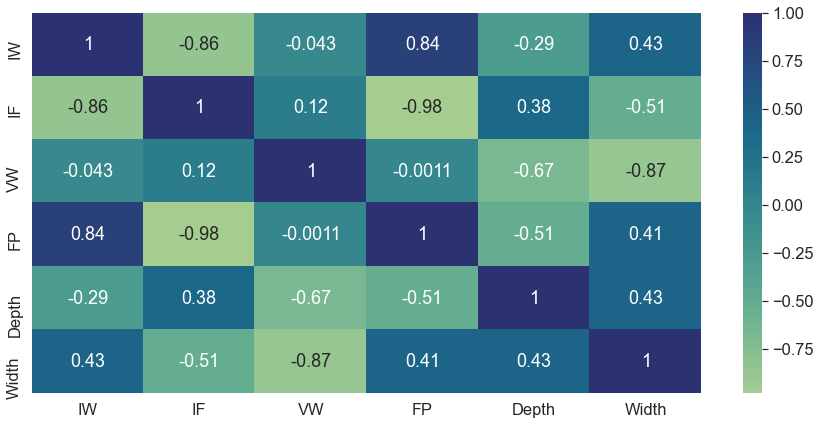

In [11]:
sns.set(font_scale=1.5) 
f, ax = plt.subplots(figsize=(15,7)) # выводим heatmap для корреляционной матрицы
sns.heatmap(corr, annot=True, ax=ax, cmap="crest")

# Визуализация исходного датасета

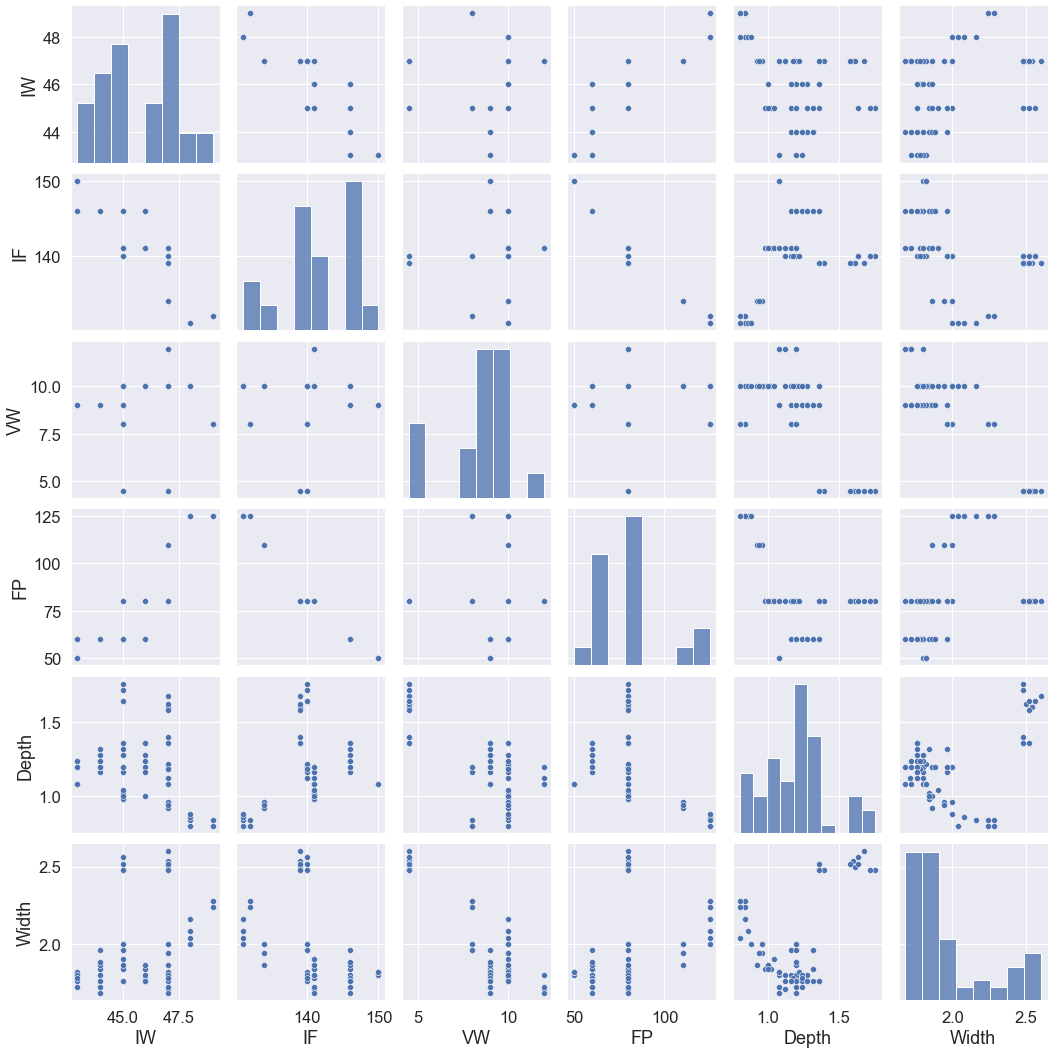

In [12]:
sns.pairplot(df)

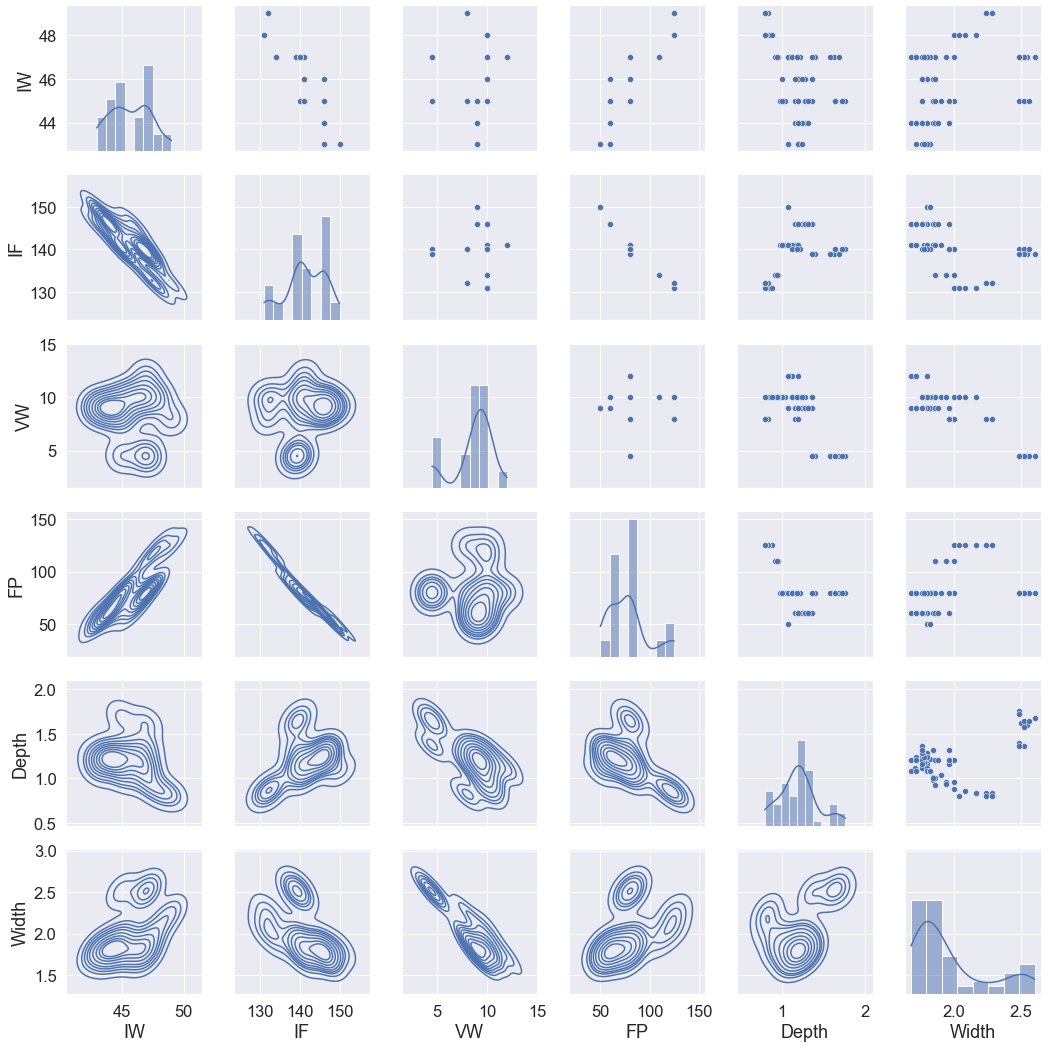

In [13]:
diagram = sns.PairGrid(df, diag_sharey=True)
diagram.map_lower(sns.kdeplot) # Ядерная оценка плотности
diagram.map_upper(sns.scatterplot) # Диаграмма рассеивания
diagram.map_diag(sns.histplot, kde=True) # Гистограмма

# Нормализация MinMaxScaler

In [14]:
minmax_scaler = MinMaxScaler()

In [15]:
dataset_norm = minmax_scaler.fit_transform(np.array(df[['IW', 'IF', 'VW', 'FP', 'Depth', 'Width']]))

In [16]:
dataset_norm[:3] #выводим первые 3 строки

array([[0.66666667, 0.42105263, 0.        , 0.4       , 0.83333333,
        0.93478261],
       [0.66666667, 0.42105263, 0.        , 0.4       , 0.85416667,
        0.89130435],
       [0.66666667, 0.42105263, 0.        , 0.4       , 0.91666667,
        1.        ]])

In [17]:
df[:3]

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60


In [18]:
df_norm = pd.DataFrame(data = dataset_norm, columns = ['IW', 'IF', 'VW', 'FP', 'Depth', 'Width'] )
df_norm.head()

,IW,IF,VW,FP,Depth,Width
0,0.666667,0.421053,0.0,0.4,0.833333,0.934783
1,0.666667,0.421053,0.0,0.4,0.854167,0.891304
2,0.666667,0.421053,0.0,0.4,0.916667,1.000000
3,0.666667,0.421053,0.0,0.4,0.812500,0.913043
4,0.333333,0.473684,0.0,0.4,1.000000,0.869565


In [19]:
df_norm.describe() #смотрим описательную статистику, все корректно отработало, т.к. все значения лежат в интервале [0, 1]

,IW,IF,VW,FP,Depth,Width
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,0.444444,0.543860,0.551852,0.377778,0.412037,0.315670
std,0.279727,0.270830,0.274810,0.286580,0.234460,0.303304
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.166667,0.421053,0.466667,0.133333,0.291667,0.086957
50%,0.416667,0.526316,0.600000,0.400000,0.416667,0.173913
75%,0.666667,0.789474,0.733333,0.400000,0.510417,0.402174
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


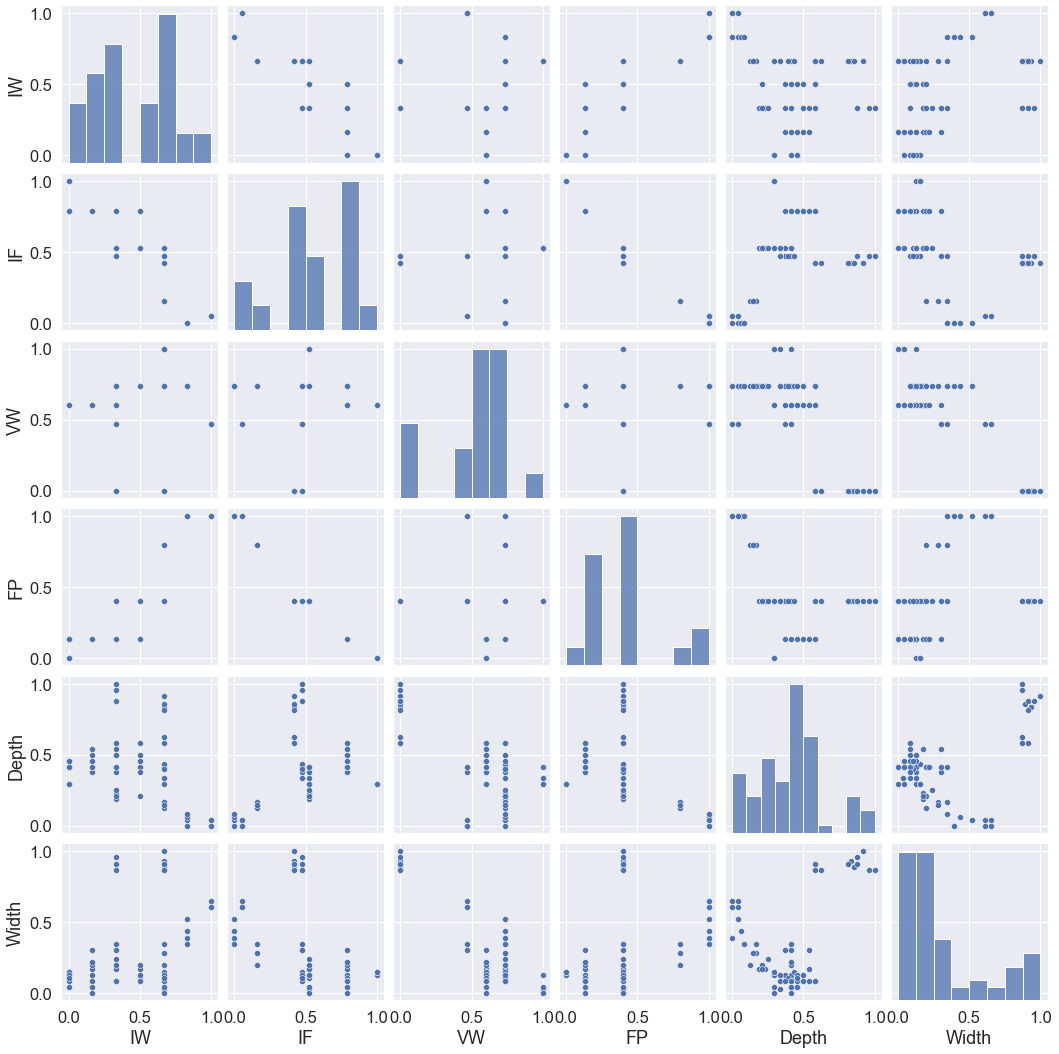

In [20]:
sns.pairplot(df_norm)

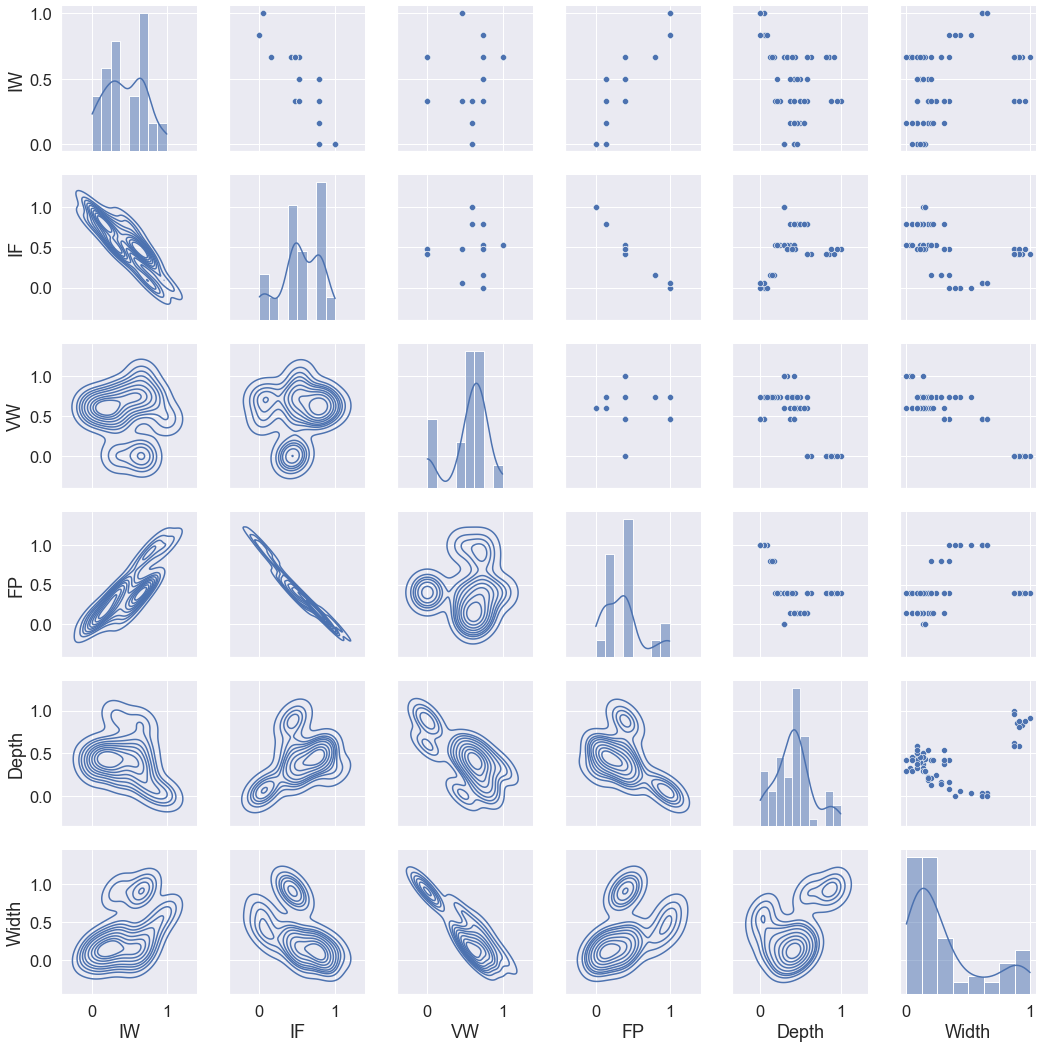

In [21]:
dg_norm = sns.PairGrid(df_norm, diag_sharey=False)
dg_norm.map_lower(sns.kdeplot)
dg_norm.map_upper(sns.scatterplot)
dg_norm.map_diag(sns.histplot, kde=True)

# Нормализация StandardScaler

In [22]:
std_scaler = StandardScaler()

In [23]:
dataset_std = std_scaler.fit_transform(np.array(df[['IW', 'IF', 'VW', 'FP', 'Depth', 'Width']]))

In [24]:
dataset_std[:3] #выводим первые 3 строки

array([[ 0.8       , -0.45662965, -2.02221044,  0.07808688,  1.80949024,
         2.05555078],
       [ 0.8       , -0.45662965, -2.02221044,  0.07808688,  1.89897053,
         1.91119608],
       [ 0.8       , -0.45662965, -2.02221044,  0.07808688,  2.16741139,
         2.27208283]])

In [25]:
df_std = pd.DataFrame(data = dataset_std, columns = ['IW', 'IF', 'VW', 'FP', 'Depth', 'Width'] )
df_std.head()

,IW,IF,VW,FP,Depth,Width
0,0.8,-0.456630,-2.02221,0.078087,1.809490,2.055551
1,0.8,-0.456630,-2.02221,0.078087,1.898971,1.911196
2,0.8,-0.456630,-2.02221,0.078087,2.167411,2.272083
3,0.8,-0.456630,-2.02221,0.078087,1.720010,1.983373
4,-0.4,-0.260931,-2.02221,0.078087,2.525333,1.839019


In [26]:
df_std.describe() #смотрим описательную статистику

,IW,IF,VW,FP,Depth,Width
count,7.200000e+01,7.200000e+01,7.200000e+01,7.200000e+01,7.200000e+01,7.200000e+01
mean,1.437122e-15,-1.844204e-15,-6.784696e-17,3.361509e-16,2.667619e-16,-1.541976e-17
std,1.007018e+00,1.007018e+00,1.007018e+00,1.007018e+00,1.007018e+00,1.007018e+00
min,-1.600000e+00,-2.022217e+00,-2.022210e+00,-1.327477e+00,-1.769721e+00,-1.048075e+00
25%,-1.000000e+00,-4.566297e-01,-3.121533e-01,-8.589557e-01,-5.169972e-01,-7.593659e-01
50%,-1.000000e-01,-6.523281e-02,1.764345e-01,7.808688e-02,1.988451e-02,-4.706565e-01
75%,8.000000e-01,9.132593e-01,6.650222e-01,7.808688e-02,4.225458e-01,2.872057e-01
max,2.000000e+00,1.696053e+00,1.642198e+00,2.186433e+00,2.525333e+00,2.272083e+00


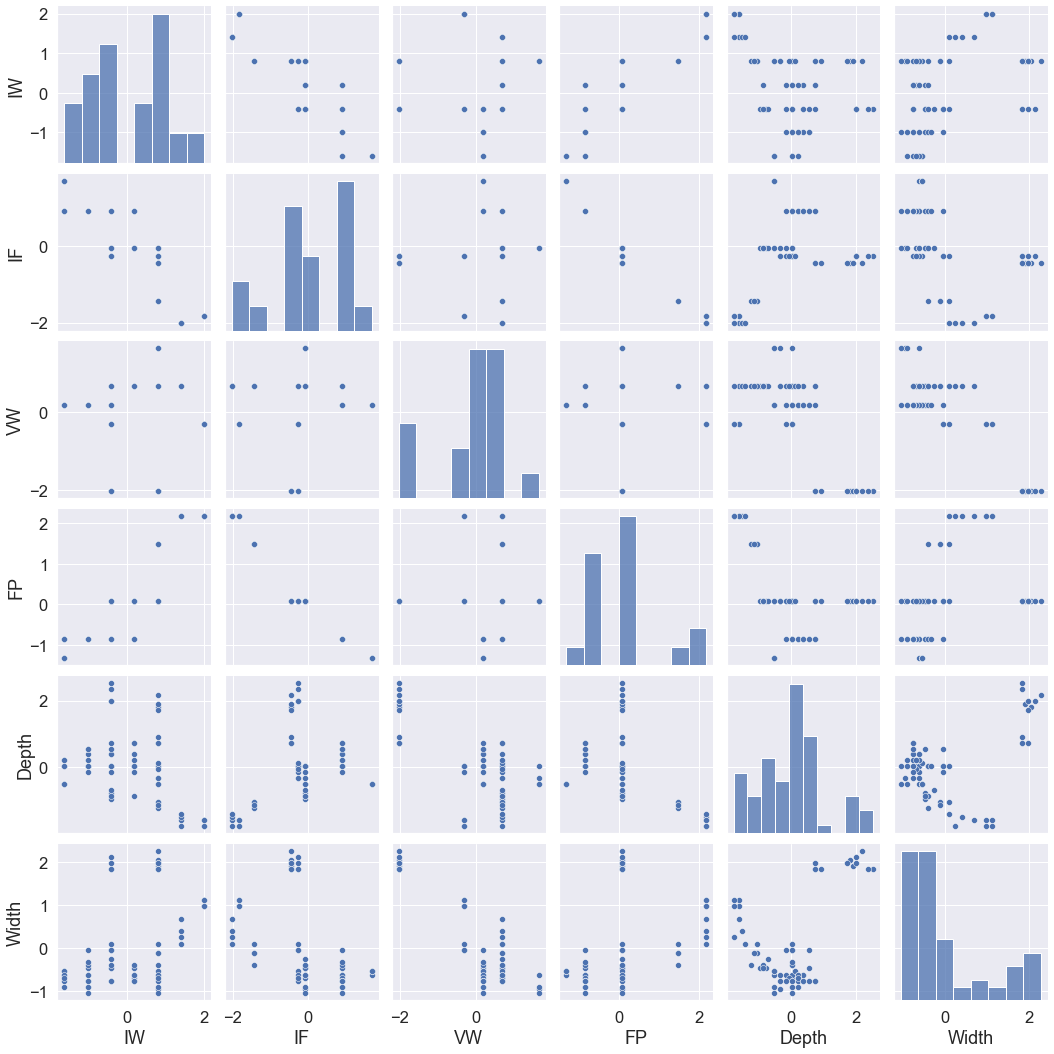

In [27]:
sns.pairplot(df_std)

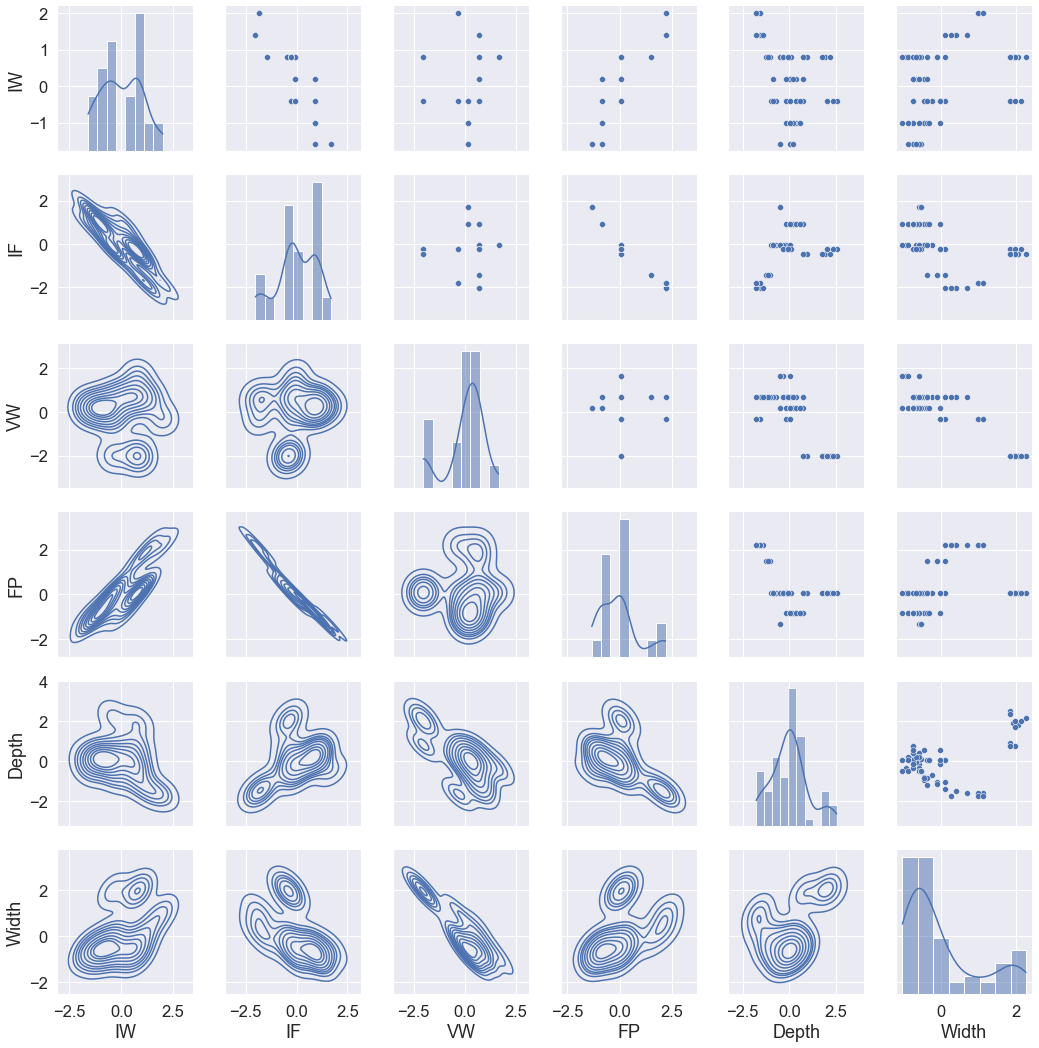

In [28]:
dg_std = sns.PairGrid(df_std, diag_sharey=False)
dg_std.map_lower(sns.kdeplot)
dg_std.map_upper(sns.scatterplot)
dg_std.map_diag(sns.histplot, kde=True)

# Поиск выбросов

Text(0, 0.5, 'Метод MinMaxScaler')

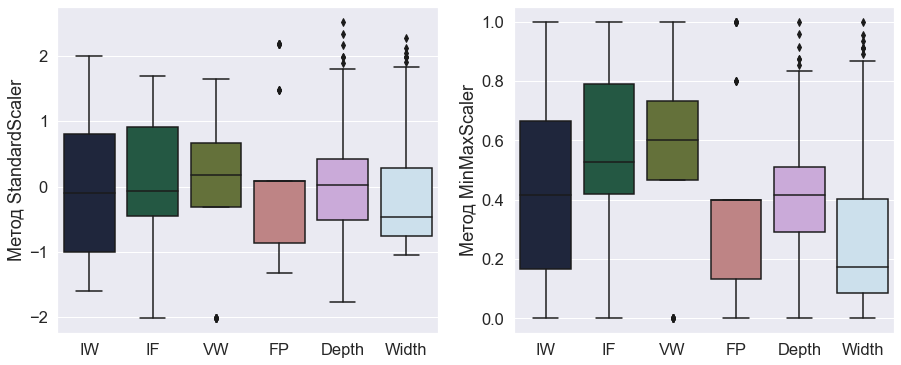

In [29]:
plt.figure(figsize=(15, 6))

plt.subplot(121)
sns.boxplot(data=df_std, palette='cubehelix') # Рисуем "ящик с усами" для датасета, нормализованного с помощью StandardScaler 
plt.ylabel('Метод StandardScaler')

plt.subplot(122)
sns.boxplot(data=df_norm, palette='cubehelix') # Рисуем "ящик с усами" для датасета, нормализованного с помощью MinMaxScaler
plt.ylabel('Метод MinMaxScaler')

In [30]:
#df = df_std # Для дальнейшей работы выбираем датасет, нормализованный с помощью StandardScalerdf
#df

# Избавляемся от выбросов через Z-оценку

In [31]:
z = np.abs(stats.zscore(df))
df_cleanZ = df[(z<3).all(axis=1)] # убираем из датасета только те записи, для которых все Z-оценки лежат в интервале [-3, 3]
df_cleanZ.shape

(72, 6)

# Избавляемся от выбросов через межквартильный размах

In [32]:
Q1 = df[['VW', 'FP']].quantile(q=.25) # первый квартиль 
Q3 = df[[ 'VW', 'FP']].quantile(q=.75) # третий квартиль 
IQR = df[['VW', 'FP']].apply(stats.iqr) # межквартильный размах

In [33]:
df_clean = df[(df['VW'] < (Q1['VW']-1.5*IQR['VW'])) | (df['VW'] > (Q1['VW']+1.5*IQR['VW']))]
df_clean, df_clean.shape

(    IW   IF    VW  FP  Depth  Width
 0   47  139   4.5  80   1.60   2.54
 1   47  139   4.5  80   1.62   2.50
 2   47  139   4.5  80   1.68   2.60
 3   47  139   4.5  80   1.58   2.52
 4   45  140   4.5  80   1.76   2.48
 5   45  140   4.5  80   1.72   2.48
 6   45  140   4.5  80   1.64   2.52
 7   45  140   4.5  80   1.64   2.56
 20  47  141  12.0  80   1.12   1.71
 21  47  141  12.0  80   1.08   1.68
 22  47  141  12.0  80   1.20   1.80
 23  47  141  12.0  80   1.08   1.72
 28  47  139   4.5  80   1.36   2.52
 29  47  139   4.5  80   1.36   2.48
 30  47  139   4.5  80   1.40   2.48
 31  47  139   4.5  80   1.36   2.48,
 (16, 6))

In [34]:
df_clean = df[(df['FP'] < (Q1['FP']-1.5*IQR['FP'])) | (df['FP'] > (Q1['FP']+1.5*IQR['FP']))]
df_clean, df_clean.shape

(    IW   IF    VW   FP  Depth  Width
 24  47  134  10.0  110   0.96   2.00
 25  47  134  10.0  110   0.96   1.94
 26  47  134  10.0  110   0.92   1.86
 27  47  134  10.0  110   0.94   1.94
 32  48  131  10.0  125   0.84   2.16
 33  48  131  10.0  125   0.86   2.08
 34  48  131  10.0  125   0.88   2.00
 35  48  131  10.0  125   0.80   2.04
 36  49  132   8.0  125   0.84   2.28
 37  49  132   8.0  125   0.84   2.24
 38  49  132   8.0  125   0.80   2.24
 39  49  132   8.0  125   0.80   2.28,
 (12, 6))

# Разделяем выборку на регрессоры X и предикторы yd, yw

In [35]:
#df = df_norm # берем минмакс датасет для работы в ИНС
#df = df_std # берем стандартизированный датасет для работы в ИНС
df

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48
...,...,...,...,...,...,...
67,44,146,9.0,60,1.20,1.72
68,45,146,9.0,60,1.36,1.76
69,45,146,9.0,60,1.28,1.76
70,45,146,9.0,60,1.28,1.76


In [36]:
predict_depth = "Depth"
predict_width = "Width"

In [37]:
X = np.array(df.drop([predict_depth, predict_width], 1))

In [38]:
yd = np.array(df[predict_depth])

In [39]:
yw = np.array(df[predict_width])

# 1 С помощью встроенных методов (без разделения на тестовую и валидацинную выборки)
## 1.1 Регрессия с помощью модуля statsmodels.api.OLS

In [40]:
X = sm.add_constant(X)
model = sm.OLS(yd, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     71.08
Date:                Tue, 22 Nov 2022   Prob (F-statistic):           2.19e-23
Time:                        16:09:17   Log-Likelihood:                 65.366
No. Observations:                  72   AIC:                            -120.7
Df Residuals:                      67   BIC:                            -109.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.7900      2.836      4.510      0.0

In [41]:
X = sm.add_constant(X)
model = sm.OLS(yw, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     279.1
Date:                Tue, 22 Nov 2022   Prob (F-statistic):           5.48e-41
Time:                        16:09:17   Log-Likelihood:                 93.608
No. Observations:                  72   AIC:                            -177.2
Df Residuals:                      67   BIC:                            -165.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9748      1.916      0.509      0.6

## 1.2 Регрессия с помощью sklearn linear_model.LinearRegression()

In [42]:
X = np.array(df.drop([predict_depth, predict_width], 1))

In [43]:
regressionD = linear_model.LinearRegression()

In [44]:
regressionD.fit(X, yd)

LinearRegression()

In [45]:
regressionD.intercept_, regressionD.coef_

(12.790012957720926,
 array([ 0.02116132, -0.07252623, -0.05199885, -0.02376048]))

In [46]:
regressionD.score(X, yd) # R^2 для Depth

0.8092951739829068

In [47]:
regressionW = linear_model.LinearRegression()

In [48]:
regressionW.fit(X, yw)

LinearRegression()

In [49]:
regressionW.intercept_, regressionW.coef_

(0.9747816679496122,
 array([ 0.0300595 ,  0.00235607, -0.11793195,  0.0039412 ]))

In [50]:
regressionW.score(X, yw) # R^2 для Width

0.9433759236085344

# 2 С разделением на тестовые и валидационные выборки

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, yd, test_size = 0.3, random_state = 42) # для Depth

In [52]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(50, 4) (22, 4) (50,) (22,)


## 2.1 Width

# 2.1.1 sklearn linear_model.LinearRegression() 

In [53]:
regressionDepth = linear_model.LinearRegression()
regressionDepth.fit(X_train, y_train)

LinearRegression()

In [54]:
regressionDepth.intercept_, regressionDepth.coef_

(12.893518794065105,
 array([ 0.02590605, -0.0743182 , -0.05283151, -0.02460041]))

In [55]:
regressionDepth.score(X_train, y_train)

0.8643345750804323

In [56]:
y_predictD = regressionDepth.predict(X_test)
y_predictD, y_test

(array([1.4489695 , 1.20551453, 1.10998403, 1.5750998 , 1.5750998 ,
        1.23142058, 1.2640592 , 0.79795983, 1.08407798, 1.1542458 ,
        1.23040117, 1.5750998 , 1.2640592 , 1.23040117, 1.4489695 ,
        1.03022705, 1.23142058, 1.23142058, 0.79795983, 0.85521071,
        1.23142058, 1.10998403]),
 array([1.76, 1.2 , 1.2 , 1.6 , 1.36, 1.24, 1.16, 0.88, 0.98, 1.08, 1.24,
        1.36, 1.2 , 1.36, 1.72, 1.2 , 1.2 , 1.32, 0.86, 0.8 , 1.2 , 1.2 ]))

In [57]:
print(" MAE =", mean_absolute_error(y_test, y_predictD), "\n", 
    "MSE =", mean_squared_error(y_test, y_predictD), "\n", 
     "R_squared =", r2_score(y_test, y_predictD))

 MAE = 0.10170050568076006 
 MSE = 0.017277234762879963 
 R_squared = 0.6976708789395969


In [58]:
res1 = ['Depth', 
         'LinearRegression', 
         mean_absolute_error(y_test, y_predictD), 
         mean_squared_error(y_test, y_predictD), 
         r2_score(y_test, y_predictD)]

In [59]:
results_comp.append(res1)

## 2.1.2 Нейросеть

In [60]:
X_train

array([[ 48. , 131. ,  10. , 125. ],
       [ 46. , 146. ,  10. ,  60. ],
       [ 45. , 146. ,   9. ,  60. ],
       [ 45. , 140. ,   4.5,  80. ],
       [ 43. , 150. ,   9. ,  50. ],
       [ 47. , 140. ,  10. ,  80. ],
       [ 47. , 139. ,   4.5,  80. ],
       [ 46. , 146. ,  10. ,  60. ],
       [ 45. , 146. ,   9. ,  60. ],
       [ 46. , 141. ,  10. ,  80. ],
       [ 44. , 146. ,   9. ,  60. ],
       [ 47. , 134. ,  10. , 110. ],
       [ 47. , 140. ,  10. ,  80. ],
       [ 45. , 141. ,  10. ,  80. ],
       [ 44. , 146. ,   9. ,  60. ],
       [ 47. , 139. ,   4.5,  80. ],
       [ 46. , 141. ,  10. ,  80. ],
       [ 49. , 132. ,   8. , 125. ],
       [ 45. , 140. ,   8. ,  80. ],
       [ 44. , 146. ,   9. ,  60. ],
       [ 45. , 140. ,   4.5,  80. ],
       [ 49. , 132. ,   8. , 125. ],
       [ 44. , 146. ,   9. ,  60. ],
       [ 43. , 150. ,   9. ,  50. ],
       [ 45. , 146. ,   9. ,  60. ],
       [ 45. , 141. ,  10. ,  80. ],
       [ 47. , 134. ,  10. , 110. ],
 

Epoch 1/1000
2/2 - 1s - loss: 1.0455 - mse: 1.0455 - mae: 0.9074 - val_loss: 8.4634 - val_mse: 8.4634 - val_mae: 2.4138 - 718ms/epoch - 359ms/step
Epoch 2/1000
2/2 - 0s - loss: 1.0754 - mse: 1.0754 - mae: 0.9210 - val_loss: 44.4431 - val_mse: 44.4431 - val_mae: 6.4571 - 34ms/epoch - 17ms/step
Epoch 3/1000
2/2 - 0s - loss: 1.0378 - mse: 1.0378 - mae: 0.8992 - val_loss: 72.4169 - val_mse: 72.4169 - val_mae: 8.3714 - 20ms/epoch - 10ms/step
Epoch 4/1000
2/2 - 0s - loss: 1.0580 - mse: 1.0580 - mae: 0.9165 - val_loss: 88.9462 - val_mse: 88.9462 - val_mae: 9.3163 - 22ms/epoch - 11ms/step
Epoch 5/1000
2/2 - 0s - loss: 1.0187 - mse: 1.0187 - mae: 0.8824 - val_loss: 99.4722 - val_mse: 99.4722 - val_mae: 9.8689 - 22ms/epoch - 11ms/step
Epoch 6/1000
2/2 - 0s - loss: 1.0214 - mse: 1.0214 - mae: 0.8897 - val_loss: 106.5470 - val_mse: 106.5470 - val_mae: 10.2233 - 21ms/epoch - 10ms/step
Epoch 7/1000
2/2 - 0s - loss: 1.0307 - mse: 1.0307 - mae: 0.8905 - val_loss: 108.6193 - val_mse: 108.6193 - val_mae

Epoch 57/1000
2/2 - 0s - loss: 0.8705 - mse: 0.8705 - mae: 0.8077 - val_loss: 19.3786 - val_mse: 19.3786 - val_mae: 4.2678 - 21ms/epoch - 10ms/step
Epoch 58/1000
2/2 - 0s - loss: 0.8419 - mse: 0.8419 - mae: 0.7788 - val_loss: 18.8209 - val_mse: 18.8209 - val_mae: 4.2023 - 21ms/epoch - 11ms/step
Epoch 59/1000
2/2 - 0s - loss: 0.8671 - mse: 0.8671 - mae: 0.8074 - val_loss: 18.3657 - val_mse: 18.3657 - val_mae: 4.1486 - 20ms/epoch - 10ms/step
Epoch 60/1000
2/2 - 0s - loss: 0.8222 - mse: 0.8222 - mae: 0.7797 - val_loss: 17.9111 - val_mse: 17.9111 - val_mae: 4.0936 - 21ms/epoch - 11ms/step
Epoch 61/1000
2/2 - 0s - loss: 0.8175 - mse: 0.8175 - mae: 0.7783 - val_loss: 17.4687 - val_mse: 17.4687 - val_mae: 4.0397 - 21ms/epoch - 11ms/step
Epoch 62/1000
2/2 - 0s - loss: 0.7871 - mse: 0.7871 - mae: 0.7662 - val_loss: 16.9600 - val_mse: 16.9600 - val_mae: 3.9762 - 21ms/epoch - 11ms/step
Epoch 63/1000
2/2 - 0s - loss: 0.7505 - mse: 0.7505 - mae: 0.7433 - val_loss: 16.5111 - val_mse: 16.5111 - val_m

Epoch 113/1000
2/2 - 0s - loss: 0.4718 - mse: 0.4718 - mae: 0.4998 - val_loss: 1.4654 - val_mse: 1.4654 - val_mae: 1.1425 - 22ms/epoch - 11ms/step
Epoch 114/1000
2/2 - 0s - loss: 0.4664 - mse: 0.4664 - mae: 0.4852 - val_loss: 1.4082 - val_mse: 1.4082 - val_mae: 1.1201 - 23ms/epoch - 11ms/step
Epoch 115/1000
2/2 - 0s - loss: 0.4684 - mse: 0.4684 - mae: 0.4749 - val_loss: 1.3540 - val_mse: 1.3540 - val_mae: 1.0981 - 21ms/epoch - 11ms/step
Epoch 116/1000
2/2 - 0s - loss: 0.4698 - mse: 0.4698 - mae: 0.4934 - val_loss: 1.3045 - val_mse: 1.3045 - val_mae: 1.0771 - 20ms/epoch - 10ms/step
Epoch 117/1000
2/2 - 0s - loss: 0.4521 - mse: 0.4521 - mae: 0.4762 - val_loss: 1.2584 - val_mse: 1.2584 - val_mae: 1.0569 - 22ms/epoch - 11ms/step
Epoch 118/1000
2/2 - 0s - loss: 0.4707 - mse: 0.4707 - mae: 0.4775 - val_loss: 1.2134 - val_mse: 1.2134 - val_mae: 1.0362 - 21ms/epoch - 10ms/step
Epoch 119/1000
2/2 - 0s - loss: 0.4599 - mse: 0.4599 - mae: 0.4620 - val_loss: 1.1750 - val_mse: 1.1750 - val_mae: 1.0

Epoch 169/1000
2/2 - 0s - loss: 0.1477 - mse: 0.1477 - mae: 0.2720 - val_loss: 0.1677 - val_mse: 0.1677 - val_mae: 0.3740 - 24ms/epoch - 12ms/step
Epoch 170/1000
2/2 - 0s - loss: 0.1421 - mse: 0.1421 - mae: 0.2672 - val_loss: 0.1529 - val_mse: 0.1529 - val_mae: 0.3575 - 21ms/epoch - 10ms/step
Epoch 171/1000
2/2 - 0s - loss: 0.1234 - mse: 0.1234 - mae: 0.2546 - val_loss: 0.1403 - val_mse: 0.1403 - val_mae: 0.3419 - 22ms/epoch - 11ms/step
Epoch 172/1000
2/2 - 0s - loss: 0.1121 - mse: 0.1121 - mae: 0.2520 - val_loss: 0.1300 - val_mse: 0.1300 - val_mae: 0.3278 - 22ms/epoch - 11ms/step
Epoch 173/1000
2/2 - 0s - loss: 0.1012 - mse: 0.1012 - mae: 0.2436 - val_loss: 0.1214 - val_mse: 0.1214 - val_mae: 0.3142 - 21ms/epoch - 10ms/step
Epoch 174/1000
2/2 - 0s - loss: 0.0959 - mse: 0.0959 - mae: 0.2420 - val_loss: 0.1144 - val_mse: 0.1144 - val_mae: 0.3018 - 21ms/epoch - 10ms/step
Epoch 175/1000
2/2 - 0s - loss: 0.0846 - mse: 0.0846 - mae: 0.2335 - val_loss: 0.1088 - val_mse: 0.1088 - val_mae: 0.2

Epoch 225/1000
2/2 - 0s - loss: 0.0213 - mse: 0.0213 - mae: 0.1075 - val_loss: 0.0448 - val_mse: 0.0448 - val_mae: 0.1639 - 21ms/epoch - 11ms/step
Epoch 226/1000
2/2 - 0s - loss: 0.0169 - mse: 0.0169 - mae: 0.0962 - val_loss: 0.0438 - val_mse: 0.0438 - val_mae: 0.1614 - 20ms/epoch - 10ms/step
Epoch 227/1000
2/2 - 0s - loss: 0.0215 - mse: 0.0215 - mae: 0.1039 - val_loss: 0.0430 - val_mse: 0.0430 - val_mae: 0.1593 - 22ms/epoch - 11ms/step
Epoch 228/1000
2/2 - 0s - loss: 0.0213 - mse: 0.0213 - mae: 0.1094 - val_loss: 0.0422 - val_mse: 0.0422 - val_mae: 0.1573 - 22ms/epoch - 11ms/step
Epoch 229/1000
2/2 - 0s - loss: 0.0327 - mse: 0.0327 - mae: 0.1231 - val_loss: 0.0414 - val_mse: 0.0414 - val_mae: 0.1551 - 21ms/epoch - 11ms/step
Epoch 230/1000
2/2 - 0s - loss: 0.0230 - mse: 0.0230 - mae: 0.1050 - val_loss: 0.0405 - val_mse: 0.0405 - val_mae: 0.1529 - 21ms/epoch - 10ms/step
Epoch 231/1000
2/2 - 0s - loss: 0.0194 - mse: 0.0194 - mae: 0.1123 - val_loss: 0.0397 - val_mse: 0.0397 - val_mae: 0.1

Epoch 281/1000
2/2 - 0s - loss: 0.0169 - mse: 0.0169 - mae: 0.0917 - val_loss: 0.0259 - val_mse: 0.0259 - val_mae: 0.1140 - 24ms/epoch - 12ms/step
Epoch 282/1000
2/2 - 0s - loss: 0.0181 - mse: 0.0181 - mae: 0.0975 - val_loss: 0.0258 - val_mse: 0.0258 - val_mae: 0.1140 - 25ms/epoch - 12ms/step
Epoch 283/1000
2/2 - 0s - loss: 0.0172 - mse: 0.0172 - mae: 0.0992 - val_loss: 0.0257 - val_mse: 0.0257 - val_mae: 0.1139 - 22ms/epoch - 11ms/step
Epoch 284/1000
2/2 - 0s - loss: 0.0169 - mse: 0.0169 - mae: 0.0944 - val_loss: 0.0255 - val_mse: 0.0255 - val_mae: 0.1142 - 22ms/epoch - 11ms/step
Epoch 285/1000
2/2 - 0s - loss: 0.0176 - mse: 0.0176 - mae: 0.1006 - val_loss: 0.0254 - val_mse: 0.0254 - val_mae: 0.1145 - 21ms/epoch - 10ms/step
Epoch 286/1000
2/2 - 0s - loss: 0.0305 - mse: 0.0305 - mae: 0.1176 - val_loss: 0.0253 - val_mse: 0.0253 - val_mae: 0.1150 - 22ms/epoch - 11ms/step
Epoch 287/1000
2/2 - 0s - loss: 0.0169 - mse: 0.0169 - mae: 0.0957 - val_loss: 0.0253 - val_mse: 0.0253 - val_mae: 0.1

Epoch 337/1000
2/2 - 0s - loss: 0.0179 - mse: 0.0179 - mae: 0.1024 - val_loss: 0.0239 - val_mse: 0.0239 - val_mae: 0.1188 - 21ms/epoch - 11ms/step
Epoch 338/1000
2/2 - 0s - loss: 0.0155 - mse: 0.0155 - mae: 0.0925 - val_loss: 0.0239 - val_mse: 0.0239 - val_mae: 0.1188 - 22ms/epoch - 11ms/step
Epoch 339/1000
2/2 - 0s - loss: 0.0170 - mse: 0.0170 - mae: 0.0894 - val_loss: 0.0238 - val_mse: 0.0238 - val_mae: 0.1190 - 21ms/epoch - 10ms/step
Epoch 340/1000
2/2 - 0s - loss: 0.0190 - mse: 0.0190 - mae: 0.0956 - val_loss: 0.0238 - val_mse: 0.0238 - val_mae: 0.1188 - 20ms/epoch - 10ms/step
Epoch 341/1000
2/2 - 0s - loss: 0.0182 - mse: 0.0182 - mae: 0.0980 - val_loss: 0.0237 - val_mse: 0.0237 - val_mae: 0.1188 - 21ms/epoch - 10ms/step
Epoch 342/1000
2/2 - 0s - loss: 0.0147 - mse: 0.0147 - mae: 0.0965 - val_loss: 0.0237 - val_mse: 0.0237 - val_mae: 0.1189 - 21ms/epoch - 11ms/step
Epoch 343/1000
2/2 - 0s - loss: 0.0158 - mse: 0.0158 - mae: 0.1001 - val_loss: 0.0237 - val_mse: 0.0237 - val_mae: 0.1

Epoch 393/1000
2/2 - 0s - loss: 0.0164 - mse: 0.0164 - mae: 0.0975 - val_loss: 0.0233 - val_mse: 0.0233 - val_mae: 0.1197 - 22ms/epoch - 11ms/step
Epoch 394/1000
2/2 - 0s - loss: 0.0161 - mse: 0.0161 - mae: 0.0945 - val_loss: 0.0233 - val_mse: 0.0233 - val_mae: 0.1195 - 21ms/epoch - 10ms/step
Epoch 395/1000
2/2 - 0s - loss: 0.0173 - mse: 0.0173 - mae: 0.0979 - val_loss: 0.0232 - val_mse: 0.0232 - val_mae: 0.1195 - 21ms/epoch - 10ms/step
Epoch 396/1000
2/2 - 0s - loss: 0.0121 - mse: 0.0121 - mae: 0.0877 - val_loss: 0.0232 - val_mse: 0.0232 - val_mae: 0.1195 - 20ms/epoch - 10ms/step
Epoch 397/1000
2/2 - 0s - loss: 0.0146 - mse: 0.0146 - mae: 0.0921 - val_loss: 0.0231 - val_mse: 0.0231 - val_mae: 0.1192 - 21ms/epoch - 10ms/step
Epoch 398/1000
2/2 - 0s - loss: 0.0168 - mse: 0.0168 - mae: 0.0957 - val_loss: 0.0230 - val_mse: 0.0230 - val_mae: 0.1190 - 21ms/epoch - 10ms/step
Epoch 399/1000
2/2 - 0s - loss: 0.0156 - mse: 0.0156 - mae: 0.0924 - val_loss: 0.0228 - val_mse: 0.0228 - val_mae: 0.1

Epoch 449/1000
2/2 - 0s - loss: 0.0121 - mse: 0.0121 - mae: 0.0872 - val_loss: 0.0220 - val_mse: 0.0220 - val_mae: 0.1148 - 20ms/epoch - 10ms/step
Epoch 450/1000
2/2 - 0s - loss: 0.0143 - mse: 0.0143 - mae: 0.0899 - val_loss: 0.0220 - val_mse: 0.0220 - val_mae: 0.1149 - 20ms/epoch - 10ms/step
Epoch 451/1000
2/2 - 0s - loss: 0.0118 - mse: 0.0118 - mae: 0.0791 - val_loss: 0.0220 - val_mse: 0.0220 - val_mae: 0.1152 - 21ms/epoch - 10ms/step
Epoch 452/1000
2/2 - 0s - loss: 0.0135 - mse: 0.0135 - mae: 0.0862 - val_loss: 0.0220 - val_mse: 0.0220 - val_mae: 0.1156 - 20ms/epoch - 10ms/step
Epoch 453/1000
2/2 - 0s - loss: 0.0193 - mse: 0.0193 - mae: 0.1008 - val_loss: 0.0220 - val_mse: 0.0220 - val_mae: 0.1157 - 21ms/epoch - 11ms/step
Epoch 454/1000
2/2 - 0s - loss: 0.0119 - mse: 0.0119 - mae: 0.0826 - val_loss: 0.0219 - val_mse: 0.0219 - val_mae: 0.1158 - 21ms/epoch - 10ms/step
Epoch 455/1000
2/2 - 0s - loss: 0.0203 - mse: 0.0203 - mae: 0.0990 - val_loss: 0.0219 - val_mse: 0.0219 - val_mae: 0.1

Epoch 505/1000
2/2 - 0s - loss: 0.0126 - mse: 0.0126 - mae: 0.0839 - val_loss: 0.0208 - val_mse: 0.0208 - val_mae: 0.1113 - 21ms/epoch - 10ms/step
Epoch 506/1000
2/2 - 0s - loss: 0.0102 - mse: 0.0102 - mae: 0.0750 - val_loss: 0.0208 - val_mse: 0.0208 - val_mae: 0.1113 - 22ms/epoch - 11ms/step
Epoch 507/1000
2/2 - 0s - loss: 0.0120 - mse: 0.0120 - mae: 0.0765 - val_loss: 0.0208 - val_mse: 0.0208 - val_mae: 0.1114 - 21ms/epoch - 11ms/step
Epoch 508/1000
2/2 - 0s - loss: 0.0185 - mse: 0.0185 - mae: 0.0939 - val_loss: 0.0208 - val_mse: 0.0208 - val_mae: 0.1115 - 21ms/epoch - 10ms/step
Epoch 509/1000
2/2 - 0s - loss: 0.0320 - mse: 0.0320 - mae: 0.1249 - val_loss: 0.0207 - val_mse: 0.0207 - val_mae: 0.1115 - 21ms/epoch - 10ms/step
Epoch 510/1000
2/2 - 0s - loss: 0.0127 - mse: 0.0127 - mae: 0.0876 - val_loss: 0.0207 - val_mse: 0.0207 - val_mae: 0.1114 - 22ms/epoch - 11ms/step
Epoch 511/1000
2/2 - 0s - loss: 0.0126 - mse: 0.0126 - mae: 0.0840 - val_loss: 0.0207 - val_mse: 0.0207 - val_mae: 0.1

Epoch 561/1000
2/2 - 0s - loss: 0.0112 - mse: 0.0112 - mae: 0.0825 - val_loss: 0.0203 - val_mse: 0.0203 - val_mae: 0.1113 - 21ms/epoch - 11ms/step
Epoch 562/1000
2/2 - 0s - loss: 0.0135 - mse: 0.0135 - mae: 0.0854 - val_loss: 0.0203 - val_mse: 0.0203 - val_mae: 0.1113 - 20ms/epoch - 10ms/step
Epoch 563/1000
2/2 - 0s - loss: 0.0115 - mse: 0.0115 - mae: 0.0743 - val_loss: 0.0203 - val_mse: 0.0203 - val_mae: 0.1112 - 20ms/epoch - 10ms/step
Epoch 564/1000
2/2 - 0s - loss: 0.0126 - mse: 0.0126 - mae: 0.0843 - val_loss: 0.0203 - val_mse: 0.0203 - val_mae: 0.1110 - 21ms/epoch - 10ms/step
Epoch 565/1000
2/2 - 0s - loss: 0.0105 - mse: 0.0105 - mae: 0.0786 - val_loss: 0.0203 - val_mse: 0.0203 - val_mae: 0.1109 - 21ms/epoch - 10ms/step
Epoch 566/1000
2/2 - 0s - loss: 0.0105 - mse: 0.0105 - mae: 0.0772 - val_loss: 0.0203 - val_mse: 0.0203 - val_mae: 0.1110 - 21ms/epoch - 10ms/step
Epoch 567/1000
2/2 - 0s - loss: 0.0095 - mse: 0.0095 - mae: 0.0726 - val_loss: 0.0203 - val_mse: 0.0203 - val_mae: 0.1

Epoch 617/1000
2/2 - 0s - loss: 0.0154 - mse: 0.0154 - mae: 0.0916 - val_loss: 0.0197 - val_mse: 0.0197 - val_mae: 0.1089 - 21ms/epoch - 11ms/step
Epoch 618/1000
2/2 - 0s - loss: 0.0111 - mse: 0.0111 - mae: 0.0797 - val_loss: 0.0197 - val_mse: 0.0197 - val_mae: 0.1089 - 21ms/epoch - 11ms/step
Epoch 619/1000
2/2 - 0s - loss: 0.0114 - mse: 0.0114 - mae: 0.0808 - val_loss: 0.0197 - val_mse: 0.0197 - val_mae: 0.1088 - 21ms/epoch - 10ms/step
Epoch 620/1000
2/2 - 0s - loss: 0.0088 - mse: 0.0088 - mae: 0.0680 - val_loss: 0.0197 - val_mse: 0.0197 - val_mae: 0.1090 - 20ms/epoch - 10ms/step
Epoch 621/1000
2/2 - 0s - loss: 0.0091 - mse: 0.0091 - mae: 0.0755 - val_loss: 0.0197 - val_mse: 0.0197 - val_mae: 0.1091 - 21ms/epoch - 10ms/step
Epoch 622/1000
2/2 - 0s - loss: 0.0112 - mse: 0.0112 - mae: 0.0813 - val_loss: 0.0197 - val_mse: 0.0197 - val_mae: 0.1092 - 21ms/epoch - 10ms/step
Epoch 623/1000
2/2 - 0s - loss: 0.0104 - mse: 0.0104 - mae: 0.0781 - val_loss: 0.0197 - val_mse: 0.0197 - val_mae: 0.1

Epoch 673/1000
2/2 - 0s - loss: 0.0112 - mse: 0.0112 - mae: 0.0775 - val_loss: 0.0193 - val_mse: 0.0193 - val_mae: 0.1083 - 21ms/epoch - 10ms/step
Epoch 674/1000
2/2 - 0s - loss: 0.0098 - mse: 0.0098 - mae: 0.0758 - val_loss: 0.0193 - val_mse: 0.0193 - val_mae: 0.1084 - 21ms/epoch - 10ms/step
Epoch 675/1000
2/2 - 0s - loss: 0.0109 - mse: 0.0109 - mae: 0.0748 - val_loss: 0.0193 - val_mse: 0.0193 - val_mae: 0.1085 - 21ms/epoch - 10ms/step
Epoch 676/1000
2/2 - 0s - loss: 0.0098 - mse: 0.0098 - mae: 0.0744 - val_loss: 0.0193 - val_mse: 0.0193 - val_mae: 0.1085 - 20ms/epoch - 10ms/step
Epoch 677/1000
2/2 - 0s - loss: 0.0139 - mse: 0.0139 - mae: 0.0806 - val_loss: 0.0193 - val_mse: 0.0193 - val_mae: 0.1086 - 20ms/epoch - 10ms/step
Epoch 678/1000
2/2 - 0s - loss: 0.0183 - mse: 0.0183 - mae: 0.0976 - val_loss: 0.0193 - val_mse: 0.0193 - val_mae: 0.1085 - 21ms/epoch - 10ms/step
Epoch 679/1000
2/2 - 0s - loss: 0.0093 - mse: 0.0093 - mae: 0.0765 - val_loss: 0.0193 - val_mse: 0.0193 - val_mae: 0.1

Epoch 729/1000
2/2 - 0s - loss: 0.0117 - mse: 0.0117 - mae: 0.0883 - val_loss: 0.0189 - val_mse: 0.0189 - val_mae: 0.1071 - 22ms/epoch - 11ms/step
Epoch 730/1000
2/2 - 0s - loss: 0.0093 - mse: 0.0093 - mae: 0.0700 - val_loss: 0.0189 - val_mse: 0.0189 - val_mae: 0.1071 - 21ms/epoch - 11ms/step
Epoch 731/1000
2/2 - 0s - loss: 0.0089 - mse: 0.0089 - mae: 0.0732 - val_loss: 0.0189 - val_mse: 0.0189 - val_mae: 0.1073 - 21ms/epoch - 10ms/step
Epoch 732/1000
2/2 - 0s - loss: 0.0080 - mse: 0.0080 - mae: 0.0662 - val_loss: 0.0189 - val_mse: 0.0189 - val_mae: 0.1077 - 21ms/epoch - 10ms/step
Epoch 733/1000
2/2 - 0s - loss: 0.0091 - mse: 0.0091 - mae: 0.0717 - val_loss: 0.0189 - val_mse: 0.0189 - val_mae: 0.1079 - 21ms/epoch - 10ms/step
Epoch 734/1000
2/2 - 0s - loss: 0.0098 - mse: 0.0098 - mae: 0.0754 - val_loss: 0.0189 - val_mse: 0.0189 - val_mae: 0.1081 - 21ms/epoch - 10ms/step
Epoch 735/1000
2/2 - 0s - loss: 0.0107 - mse: 0.0107 - mae: 0.0783 - val_loss: 0.0190 - val_mse: 0.0190 - val_mae: 0.1

Epoch 785/1000
2/2 - 0s - loss: 0.0088 - mse: 0.0088 - mae: 0.0702 - val_loss: 0.0186 - val_mse: 0.0186 - val_mae: 0.1068 - 21ms/epoch - 10ms/step
Epoch 786/1000
2/2 - 0s - loss: 0.0072 - mse: 0.0072 - mae: 0.0693 - val_loss: 0.0187 - val_mse: 0.0187 - val_mae: 0.1070 - 21ms/epoch - 10ms/step
Epoch 787/1000
2/2 - 0s - loss: 0.0084 - mse: 0.0084 - mae: 0.0704 - val_loss: 0.0187 - val_mse: 0.0187 - val_mae: 0.1072 - 22ms/epoch - 11ms/step
Epoch 788/1000
2/2 - 0s - loss: 0.0082 - mse: 0.0082 - mae: 0.0726 - val_loss: 0.0187 - val_mse: 0.0187 - val_mae: 0.1074 - 21ms/epoch - 10ms/step
Epoch 789/1000
2/2 - 0s - loss: 0.0071 - mse: 0.0071 - mae: 0.0665 - val_loss: 0.0188 - val_mse: 0.0188 - val_mae: 0.1078 - 21ms/epoch - 10ms/step
Epoch 790/1000
2/2 - 0s - loss: 0.0098 - mse: 0.0098 - mae: 0.0766 - val_loss: 0.0188 - val_mse: 0.0188 - val_mae: 0.1079 - 22ms/epoch - 11ms/step
Epoch 791/1000
2/2 - 0s - loss: 0.0090 - mse: 0.0090 - mae: 0.0744 - val_loss: 0.0188 - val_mse: 0.0188 - val_mae: 0.1

Epoch 841/1000
2/2 - 0s - loss: 0.0090 - mse: 0.0090 - mae: 0.0754 - val_loss: 0.0185 - val_mse: 0.0185 - val_mae: 0.1061 - 21ms/epoch - 10ms/step
Epoch 842/1000
2/2 - 0s - loss: 0.0086 - mse: 0.0086 - mae: 0.0709 - val_loss: 0.0185 - val_mse: 0.0185 - val_mae: 0.1062 - 22ms/epoch - 11ms/step
Epoch 843/1000
2/2 - 0s - loss: 0.0082 - mse: 0.0082 - mae: 0.0699 - val_loss: 0.0185 - val_mse: 0.0185 - val_mae: 0.1062 - 21ms/epoch - 11ms/step
Epoch 844/1000
2/2 - 0s - loss: 0.0077 - mse: 0.0077 - mae: 0.0682 - val_loss: 0.0185 - val_mse: 0.0185 - val_mae: 0.1063 - 21ms/epoch - 10ms/step
Epoch 845/1000
2/2 - 0s - loss: 0.0077 - mse: 0.0077 - mae: 0.0695 - val_loss: 0.0184 - val_mse: 0.0184 - val_mae: 0.1063 - 21ms/epoch - 10ms/step
Epoch 846/1000
2/2 - 0s - loss: 0.0105 - mse: 0.0105 - mae: 0.0780 - val_loss: 0.0184 - val_mse: 0.0184 - val_mae: 0.1062 - 21ms/epoch - 11ms/step
Epoch 847/1000
2/2 - 0s - loss: 0.0077 - mse: 0.0077 - mae: 0.0683 - val_loss: 0.0184 - val_mse: 0.0184 - val_mae: 0.1

Epoch 897/1000
2/2 - 0s - loss: 0.0077 - mse: 0.0077 - mae: 0.0635 - val_loss: 0.0182 - val_mse: 0.0182 - val_mae: 0.1056 - 21ms/epoch - 10ms/step
Epoch 898/1000
2/2 - 0s - loss: 0.0074 - mse: 0.0074 - mae: 0.0663 - val_loss: 0.0181 - val_mse: 0.0181 - val_mae: 0.1055 - 21ms/epoch - 11ms/step
Epoch 899/1000
2/2 - 0s - loss: 0.0069 - mse: 0.0069 - mae: 0.0640 - val_loss: 0.0181 - val_mse: 0.0181 - val_mae: 0.1054 - 21ms/epoch - 10ms/step
Epoch 900/1000
2/2 - 0s - loss: 0.0155 - mse: 0.0155 - mae: 0.0909 - val_loss: 0.0181 - val_mse: 0.0181 - val_mae: 0.1054 - 20ms/epoch - 10ms/step
Epoch 901/1000
2/2 - 0s - loss: 0.0074 - mse: 0.0074 - mae: 0.0667 - val_loss: 0.0181 - val_mse: 0.0181 - val_mae: 0.1052 - 20ms/epoch - 10ms/step
Epoch 902/1000
2/2 - 0s - loss: 0.0092 - mse: 0.0092 - mae: 0.0736 - val_loss: 0.0180 - val_mse: 0.0180 - val_mae: 0.1050 - 20ms/epoch - 10ms/step
Epoch 903/1000
2/2 - 0s - loss: 0.0093 - mse: 0.0093 - mae: 0.0778 - val_loss: 0.0180 - val_mse: 0.0180 - val_mae: 0.1

Epoch 953/1000
2/2 - 0s - loss: 0.0111 - mse: 0.0111 - mae: 0.0742 - val_loss: 0.0179 - val_mse: 0.0179 - val_mae: 0.1044 - 22ms/epoch - 11ms/step
Epoch 954/1000
2/2 - 0s - loss: 0.0145 - mse: 0.0145 - mae: 0.0892 - val_loss: 0.0178 - val_mse: 0.0178 - val_mae: 0.1043 - 21ms/epoch - 10ms/step
Epoch 955/1000
2/2 - 0s - loss: 0.0125 - mse: 0.0125 - mae: 0.0874 - val_loss: 0.0178 - val_mse: 0.0178 - val_mae: 0.1042 - 21ms/epoch - 10ms/step
Epoch 956/1000
2/2 - 0s - loss: 0.0085 - mse: 0.0085 - mae: 0.0734 - val_loss: 0.0178 - val_mse: 0.0178 - val_mae: 0.1042 - 21ms/epoch - 10ms/step
Epoch 957/1000
2/2 - 0s - loss: 0.0092 - mse: 0.0092 - mae: 0.0721 - val_loss: 0.0177 - val_mse: 0.0177 - val_mae: 0.1042 - 20ms/epoch - 10ms/step
Epoch 958/1000
2/2 - 0s - loss: 0.0076 - mse: 0.0076 - mae: 0.0678 - val_loss: 0.0178 - val_mse: 0.0178 - val_mae: 0.1046 - 21ms/epoch - 10ms/step
Epoch 959/1000
2/2 - 0s - loss: 0.0075 - mse: 0.0075 - mae: 0.0666 - val_loss: 0.0178 - val_mse: 0.0178 - val_mae: 0.1

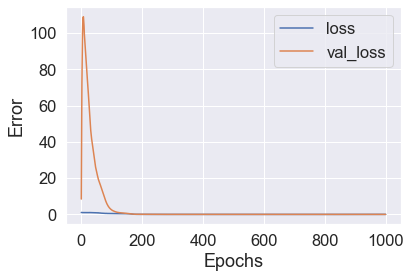

In [61]:
model = Sequential()
model.add(BatchNormalization())
model.add(Dense(X_train.shape[1], input_dim = X_train.shape[1], activation='linear'))
model.add(BatchNormalization())
model.add(Dense(1, activation='relu'))
model.compile(loss='mse', optimizer="adam", metrics=['mse', 'mae'])
history = model.fit(X_train, y_train,
                    epochs=1000,
                    verbose=2,
                    validation_data=(X_test, y_test))

plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()
plt.show()

In [62]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 4)                16        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 4)                 20        
                                                                 
 batch_normalization_1 (Batc  (None, 4)                16        
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 57
Trainable params: 41
Non-trainable params: 16
_________________________________________________________________


In [63]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 17ms/step - loss: 0.0177 - mse: 0.0177 - mae: 0.1036


[0.017738377675414085, 0.017738377675414085, 0.10356202721595764]

In [64]:
y_preds = model.predict(X_test)

1/1 [==============================] - 0s 71ms/step


In [65]:
print(y_test)

[1.76 1.2  1.2  1.6  1.36 1.24 1.16 0.88 0.98 1.08 1.24 1.36 1.2  1.36
 1.72 1.2  1.2  1.32 0.86 0.8  1.2  1.2 ]


In [66]:
print(y_preds)

[[1.4498438]
 [1.191571 ]
 [1.0967789]
 [1.568319 ]
 [1.568319 ]
 [1.2290796]
 [1.2289523]
 [0.7930083]
 [1.0592701]
 [1.1984862]
 [1.2409853]
 [1.568319 ]
 [1.2289523]
 [1.2409853]
 [1.4498438]
 [1.0080642]
 [1.2290796]
 [1.2290796]
 [0.7930083]
 [0.9132817]
 [1.2290796]
 [1.0967789]]


In [114]:
X_test

array([[ 45. , 140. ,   4.5,  80. ],
       [ 43. , 146. ,   9. ,  60. ],
       [ 46. , 141. ,  10. ,  80. ],
       [ 47. , 139. ,   4.5,  80. ],
       [ 47. , 139. ,   4.5,  80. ],
       [ 44. , 146. ,   9. ,  60. ],
       [ 45. , 140. ,   8. ,  80. ],
       [ 48. , 131. ,  10. , 125. ],
       [ 45. , 141. ,  10. ,  80. ],
       [ 43. , 150. ,   9. ,  50. ],
       [ 46. , 146. ,  10. ,  60. ],
       [ 47. , 139. ,   4.5,  80. ],
       [ 45. , 140. ,   8. ,  80. ],
       [ 46. , 146. ,  10. ,  60. ],
       [ 45. , 140. ,   4.5,  80. ],
       [ 47. , 141. ,  12. ,  80. ],
       [ 44. , 146. ,   9. ,  60. ],
       [ 44. , 146. ,   9. ,  60. ],
       [ 48. , 131. ,  10. , 125. ],
       [ 49. , 132. ,   8. , 125. ],
       [ 44. , 146. ,   9. ,  60. ],
       [ 46. , 141. ,  10. ,  80. ]])

In [67]:
print(" MAE =", mean_absolute_error(y_test, y_preds), "\n", 
    "MSE =", mean_squared_error(y_test, y_preds), "\n", 
     "R_squared =", r2_score(y_test,y_preds))

 MAE = 0.10356202277270231 
 MSE = 0.017738374242017248 
 R_squared = 0.6896015382535883


In [68]:
res3 = ['Depth', 
         'Neural', 
         mean_absolute_error(y_test, y_preds), 
         mean_squared_error(y_test, y_preds), 
         r2_score(y_test, y_preds)]
results_comp.append(res3)

In [69]:
model.save('./model_Depth.h5')

In [70]:
loaded_depth_model= load_model('./model_Depth.h5')

In [71]:
loaded_depth_model.predict(X_test)

1/1 [==============================] - 0s 56ms/step


array([[1.4498438],
       [1.191571 ],
       [1.0967789],
       [1.568319 ],
       [1.568319 ],
       [1.2290796],
       [1.2289523],
       [0.7930083],
       [1.0592701],
       [1.1984862],
       [1.2409853],
       [1.568319 ],
       [1.2289523],
       [1.2409853],
       [1.4498438],
       [1.0080642],
       [1.2290796],
       [1.2290796],
       [0.7930083],
       [0.9132817],
       [1.2290796],
       [1.0967789]], dtype=float32)

In [72]:
np.array([[10, 20, 20, 7]])

array([[10, 20, 20,  7]])

In [73]:
minmax_scaler = MinMaxScaler()

input_norm = minmax_scaler.fit_transform(np.array([[10, 5, 2, 7]]))
input_norm

array([[0., 0., 0., 0.]])

# 2.1.3 Решающий лес

In [74]:
tree = DecisionTreeRegressor()

In [75]:
tree.fit(X_train, y_train)

DecisionTreeRegressor()

In [76]:
y_pred_tree = tree.predict(X_test)

In [77]:
print(" MAE =", mean_absolute_error(y_test, y_pred_tree), "\n", 
    "MSE =", mean_squared_error(y_test, y_pred_tree), "\n", 
     "R_squared =", r2_score(y_test, y_pred_tree))

 MAE = 0.06672727272727272 
 MSE = 0.00686054545454545 
 R_squared = 0.879949383930121


In [78]:
res5 = ['Depth', 
         'Decision Tree', 
         mean_absolute_error(y_test, y_pred_tree), 
         mean_squared_error(y_test, y_pred_tree), 
         r2_score(y_test, y_pred_tree)]
results_comp.append(res5)

# 2.1.4 Случайный лес

In [79]:
model = RandomForestRegressor(n_estimators = 13, random_state=30)
model.fit(X_train, y_train)
y_pred_RF = model.predict(X_test)

In [80]:
print(" MAE =", mean_absolute_error(y_test, y_pred_RF), "\n", 
    "MSE =", mean_squared_error(y_test, y_pred_RF), "\n", 
     "R_squared =", r2_score(y_test,y_pred_RF))

 MAE = 0.07011796536796537 
 MSE = 0.007539722020807411 
 R_squared = 0.8680646780069277


In [81]:
res7 = ['Depth', 
         'Random Forest', 
         mean_absolute_error(y_test, y_pred_RF), 
         mean_squared_error(y_test, y_pred_RF), 
         r2_score(y_test, y_pred_RF)]
results_comp.append(res7)

# 3.1 WIDTH

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, yw, test_size = 0.3, random_state = 42) # для Width

In [83]:
X_test, type(X_test)

(array([[ 45. , 140. ,   4.5,  80. ],
        [ 43. , 146. ,   9. ,  60. ],
        [ 46. , 141. ,  10. ,  80. ],
        [ 47. , 139. ,   4.5,  80. ],
        [ 47. , 139. ,   4.5,  80. ],
        [ 44. , 146. ,   9. ,  60. ],
        [ 45. , 140. ,   8. ,  80. ],
        [ 48. , 131. ,  10. , 125. ],
        [ 45. , 141. ,  10. ,  80. ],
        [ 43. , 150. ,   9. ,  50. ],
        [ 46. , 146. ,  10. ,  60. ],
        [ 47. , 139. ,   4.5,  80. ],
        [ 45. , 140. ,   8. ,  80. ],
        [ 46. , 146. ,  10. ,  60. ],
        [ 45. , 140. ,   4.5,  80. ],
        [ 47. , 141. ,  12. ,  80. ],
        [ 44. , 146. ,   9. ,  60. ],
        [ 44. , 146. ,   9. ,  60. ],
        [ 48. , 131. ,  10. , 125. ],
        [ 49. , 132. ,   8. , 125. ],
        [ 44. , 146. ,   9. ,  60. ],
        [ 46. , 141. ,  10. ,  80. ]]),
 numpy.ndarray)

# 3.1.1 sklearn linear_model.LinearRegression()

In [84]:
regressionWidth = linear_model.LinearRegression()
regressionWidth.fit(X_train, y_train)

LinearRegression()

In [85]:
regressionWidth.intercept_, regressionWidth.coef_

(2.036588892297869,
 array([ 0.0192642 , -0.00151928, -0.11853297,  0.00372826]))

In [86]:
regressionWidth.score(X_train, y_train)

0.9341681373318841

In [87]:
y_predictW = regressionWidth.predict(X_test)
y_predictW, y_test

(array([2.45564144, 1.8000337 , 1.82145503, 2.49568913, 2.49568913,
        1.81929791, 2.04077604, 2.04294811, 1.80219082, 1.75667394,
        1.73929334, 2.49568913, 2.04077604, 1.73929334, 2.45564144,
        1.60365329, 1.81929791, 1.81929791, 2.04294811, 2.29775898,
        1.81929791, 1.82145503]),
 array([2.48, 1.72, 1.86, 2.54, 2.52, 1.8 , 1.96, 2.  , 1.84, 1.82, 1.76,
        2.48, 1.96, 1.76, 2.48, 1.8 , 1.76, 1.84, 2.08, 2.28, 1.76, 1.78]))

In [88]:
print(" MAE =", mean_absolute_error(y_test, y_predictW), "\n", 
    "MSE =", mean_squared_error(y_test, y_predictW), "\n", 
     "R_squared =", r2_score(y_test, y_predictW))

 MAE = 0.0477210830797381 
 MSE = 0.0037664538942062706 
 R_squared = 0.9558783912404679


In [89]:
res2 = ['Width', 
         'LinearRegression', 
         mean_absolute_error(y_test, y_predictW), 
         mean_squared_error(y_test, y_predictW), 
         r2_score(y_test, y_predictW)]

In [90]:
results_comp.append(res2)

# 3.1.2 Нейросеть

Epoch 1/1000
2/2 [==============================] - 1s 135ms/step - loss: 2.8784 - mse: 2.8784 - mae: 1.5858 - val_loss: 4.1364 - val_mse: 4.1364 - val_mae: 2.0127
Epoch 2/1000
2/2 [==============================] - 0s 21ms/step - loss: 2.8893 - mse: 2.8893 - mae: 1.5771 - val_loss: 4.1364 - val_mse: 4.1364 - val_mae: 2.0127
Epoch 3/1000
2/2 [==============================] - 0s 22ms/step - loss: 2.8722 - mse: 2.8722 - mae: 1.5718 - val_loss: 4.1364 - val_mse: 4.1364 - val_mae: 2.0127
Epoch 4/1000
2/2 [==============================] - 0s 22ms/step - loss: 2.8519 - mse: 2.8519 - mae: 1.5688 - val_loss: 4.1364 - val_mse: 4.1364 - val_mae: 2.0127
Epoch 5/1000
2/2 [==============================] - 0s 21ms/step - loss: 2.8263 - mse: 2.8263 - mae: 1.5494 - val_loss: 4.1364 - val_mse: 4.1364 - val_mae: 2.0127
Epoch 6/1000
2/2 [==============================] - 0s 20ms/step - loss: 2.8205 - mse: 2.8205 - mae: 1.5499 - val_loss: 4.1364 - val_mse: 4.1364 - val_mae: 2.0127
Epoch 7/1000
2/2 [===

2/2 [==============================] - 0s 20ms/step - loss: 2.5631 - mse: 2.5631 - mae: 1.4311 - val_loss: 3.9918 - val_mse: 3.9918 - val_mae: 1.9730
Epoch 52/1000
2/2 [==============================] - 0s 20ms/step - loss: 2.5052 - mse: 2.5052 - mae: 1.3834 - val_loss: 3.9732 - val_mse: 3.9732 - val_mae: 1.9671
Epoch 53/1000
2/2 [==============================] - 0s 19ms/step - loss: 2.5067 - mse: 2.5067 - mae: 1.3947 - val_loss: 3.9553 - val_mse: 3.9553 - val_mae: 1.9612
Epoch 54/1000
2/2 [==============================] - 0s 19ms/step - loss: 2.5352 - mse: 2.5352 - mae: 1.4116 - val_loss: 3.9402 - val_mse: 3.9402 - val_mae: 1.9559
Epoch 55/1000
2/2 [==============================] - 0s 20ms/step - loss: 2.5179 - mse: 2.5179 - mae: 1.3924 - val_loss: 3.9255 - val_mse: 3.9255 - val_mae: 1.9506
Epoch 56/1000
2/2 [==============================] - 0s 20ms/step - loss: 2.5306 - mse: 2.5306 - mae: 1.3986 - val_loss: 3.9101 - val_mse: 3.9101 - val_mae: 1.9448
Epoch 57/1000
2/2 [===========

2/2 [==============================] - 0s 20ms/step - loss: 2.3393 - mse: 2.3393 - mae: 1.3193 - val_loss: 2.9540 - val_mse: 2.9540 - val_mae: 1.5461
Epoch 102/1000
2/2 [==============================] - 0s 20ms/step - loss: 2.3287 - mse: 2.3287 - mae: 1.3116 - val_loss: 2.9424 - val_mse: 2.9424 - val_mae: 1.5410
Epoch 103/1000
2/2 [==============================] - 0s 19ms/step - loss: 2.3831 - mse: 2.3831 - mae: 1.3387 - val_loss: 2.9331 - val_mse: 2.9331 - val_mae: 1.5367
Epoch 104/1000
2/2 [==============================] - 0s 20ms/step - loss: 2.3210 - mse: 2.3210 - mae: 1.3074 - val_loss: 2.9224 - val_mse: 2.9224 - val_mae: 1.5313
Epoch 105/1000
2/2 [==============================] - 0s 20ms/step - loss: 2.3093 - mse: 2.3093 - mae: 1.3156 - val_loss: 2.9075 - val_mse: 2.9075 - val_mae: 1.5243
Epoch 106/1000
2/2 [==============================] - 0s 20ms/step - loss: 2.2898 - mse: 2.2898 - mae: 1.3015 - val_loss: 2.8788 - val_mse: 2.8788 - val_mae: 1.5127
Epoch 107/1000
2/2 [=====

Epoch 151/1000
2/2 [==============================] - 0s 20ms/step - loss: 1.4921 - mse: 1.4921 - mae: 0.9071 - val_loss: 2.0997 - val_mse: 2.0997 - val_mae: 1.1838
Epoch 152/1000
2/2 [==============================] - 0s 20ms/step - loss: 1.4633 - mse: 1.4633 - mae: 0.9123 - val_loss: 2.0901 - val_mse: 2.0901 - val_mae: 1.1795
Epoch 153/1000
2/2 [==============================] - 0s 19ms/step - loss: 1.7315 - mse: 1.7315 - mae: 1.0131 - val_loss: 2.0853 - val_mse: 2.0853 - val_mae: 1.1776
Epoch 154/1000
2/2 [==============================] - 0s 19ms/step - loss: 1.4018 - mse: 1.4018 - mae: 0.8698 - val_loss: 2.0787 - val_mse: 2.0787 - val_mae: 1.1751
Epoch 155/1000
2/2 [==============================] - 0s 20ms/step - loss: 1.3783 - mse: 1.3783 - mae: 0.8679 - val_loss: 2.0705 - val_mse: 2.0705 - val_mae: 1.1712
Epoch 156/1000
2/2 [==============================] - 0s 20ms/step - loss: 1.4173 - mse: 1.4173 - mae: 0.8799 - val_loss: 2.0618 - val_mse: 2.0618 - val_mae: 1.1675
Epoch 157/

Epoch 201/1000
2/2 [==============================] - 0s 20ms/step - loss: 1.1997 - mse: 1.1997 - mae: 0.7669 - val_loss: 1.7070 - val_mse: 1.7070 - val_mae: 0.9465
Epoch 202/1000
2/2 [==============================] - 0s 20ms/step - loss: 1.1431 - mse: 1.1431 - mae: 0.7177 - val_loss: 1.7009 - val_mse: 1.7009 - val_mae: 0.9424
Epoch 203/1000
2/2 [==============================] - 0s 20ms/step - loss: 1.1257 - mse: 1.1257 - mae: 0.7243 - val_loss: 1.6942 - val_mse: 1.6942 - val_mae: 0.9380
Epoch 204/1000
2/2 [==============================] - 0s 19ms/step - loss: 1.1369 - mse: 1.1369 - mae: 0.7216 - val_loss: 1.6888 - val_mse: 1.6888 - val_mae: 0.9348
Epoch 205/1000
2/2 [==============================] - 0s 20ms/step - loss: 1.1228 - mse: 1.1228 - mae: 0.7118 - val_loss: 1.6833 - val_mse: 1.6833 - val_mae: 0.9310
Epoch 206/1000
2/2 [==============================] - 0s 20ms/step - loss: 1.1752 - mse: 1.1752 - mae: 0.7360 - val_loss: 1.6788 - val_mse: 1.6788 - val_mae: 0.9279
Epoch 207/

Epoch 251/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.1436 - mse: 0.1436 - mae: 0.3153 - val_loss: 0.1820 - val_mse: 0.1820 - val_mae: 0.3838
Epoch 252/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.1465 - mse: 0.1465 - mae: 0.3059 - val_loss: 0.1678 - val_mse: 0.1678 - val_mae: 0.3703
Epoch 253/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.1229 - mse: 0.1229 - mae: 0.3002 - val_loss: 0.1555 - val_mse: 0.1555 - val_mae: 0.3578
Epoch 254/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.1069 - mse: 0.1069 - mae: 0.2853 - val_loss: 0.1443 - val_mse: 0.1443 - val_mae: 0.3456
Epoch 255/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.1017 - mse: 0.1017 - mae: 0.2762 - val_loss: 0.1336 - val_mse: 0.1336 - val_mae: 0.3337
Epoch 256/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.0982 - mse: 0.0982 - mae: 0.2697 - val_loss: 0.1239 - val_mse: 0.1239 - val_mae: 0.3222
Epoch 257/

Epoch 301/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0169 - mse: 0.0169 - mae: 0.1036 - val_loss: 0.0079 - val_mse: 0.0079 - val_mae: 0.0715
Epoch 302/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0153 - mse: 0.0153 - mae: 0.0966 - val_loss: 0.0077 - val_mse: 0.0077 - val_mae: 0.0702
Epoch 303/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0107 - mse: 0.0107 - mae: 0.0837 - val_loss: 0.0075 - val_mse: 0.0075 - val_mae: 0.0691
Epoch 304/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0092 - mse: 0.0092 - mae: 0.0757 - val_loss: 0.0073 - val_mse: 0.0073 - val_mae: 0.0684
Epoch 305/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0127 - mse: 0.0127 - mae: 0.0921 - val_loss: 0.0071 - val_mse: 0.0071 - val_mae: 0.0675
Epoch 306/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0136 - mse: 0.0136 - mae: 0.0960 - val_loss: 0.0070 - val_mse: 0.0070 - val_mae: 0.0666
Epoch 307/

Epoch 351/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0089 - mse: 0.0089 - mae: 0.0764 - val_loss: 0.0054 - val_mse: 0.0054 - val_mae: 0.0584
Epoch 352/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0127 - mse: 0.0127 - mae: 0.0890 - val_loss: 0.0053 - val_mse: 0.0053 - val_mae: 0.0585
Epoch 353/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0129 - mse: 0.0129 - mae: 0.0886 - val_loss: 0.0053 - val_mse: 0.0053 - val_mae: 0.0584
Epoch 354/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0085 - mse: 0.0085 - mae: 0.0671 - val_loss: 0.0053 - val_mse: 0.0053 - val_mae: 0.0583
Epoch 355/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.0084 - mse: 0.0084 - mae: 0.0733 - val_loss: 0.0053 - val_mse: 0.0053 - val_mae: 0.0583
Epoch 356/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.0272 - mse: 0.0272 - mae: 0.1199 - val_loss: 0.0053 - val_mse: 0.0053 - val_mae: 0.0585
Epoch 357/

Epoch 401/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0054 - mse: 0.0054 - mae: 0.0614 - val_loss: 0.0052 - val_mse: 0.0052 - val_mae: 0.0568
Epoch 402/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0098 - mse: 0.0098 - mae: 0.0812 - val_loss: 0.0053 - val_mse: 0.0053 - val_mae: 0.0567
Epoch 403/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0090 - mse: 0.0090 - mae: 0.0744 - val_loss: 0.0053 - val_mse: 0.0053 - val_mae: 0.0567
Epoch 404/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0233 - mse: 0.0233 - mae: 0.1190 - val_loss: 0.0053 - val_mse: 0.0053 - val_mae: 0.0566
Epoch 405/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0160 - mse: 0.0160 - mae: 0.1040 - val_loss: 0.0052 - val_mse: 0.0052 - val_mae: 0.0565
Epoch 406/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.0136 - mse: 0.0136 - mae: 0.0929 - val_loss: 0.0052 - val_mse: 0.0052 - val_mae: 0.0564
Epoch 407/

Epoch 451/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0099 - mse: 0.0099 - mae: 0.0804 - val_loss: 0.0050 - val_mse: 0.0050 - val_mae: 0.0554
Epoch 452/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0187 - mse: 0.0187 - mae: 0.1165 - val_loss: 0.0050 - val_mse: 0.0050 - val_mae: 0.0555
Epoch 453/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.0154 - mse: 0.0154 - mae: 0.1038 - val_loss: 0.0050 - val_mse: 0.0050 - val_mae: 0.0555
Epoch 454/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.0130 - mse: 0.0130 - mae: 0.0928 - val_loss: 0.0050 - val_mse: 0.0050 - val_mae: 0.0555
Epoch 455/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0079 - mse: 0.0079 - mae: 0.0761 - val_loss: 0.0051 - val_mse: 0.0051 - val_mae: 0.0558
Epoch 456/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0075 - mse: 0.0075 - mae: 0.0694 - val_loss: 0.0050 - val_mse: 0.0050 - val_mae: 0.0561
Epoch 457/

Epoch 501/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.0143 - mse: 0.0143 - mae: 0.0975 - val_loss: 0.0050 - val_mse: 0.0050 - val_mae: 0.0552
Epoch 502/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0089 - mse: 0.0089 - mae: 0.0742 - val_loss: 0.0051 - val_mse: 0.0051 - val_mae: 0.0555
Epoch 503/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0067 - mse: 0.0067 - mae: 0.0686 - val_loss: 0.0050 - val_mse: 0.0050 - val_mae: 0.0556
Epoch 504/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.0185 - mse: 0.0185 - mae: 0.1143 - val_loss: 0.0051 - val_mse: 0.0051 - val_mae: 0.0559
Epoch 505/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0065 - mse: 0.0065 - mae: 0.0662 - val_loss: 0.0051 - val_mse: 0.0051 - val_mae: 0.0558
Epoch 506/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0111 - mse: 0.0111 - mae: 0.0863 - val_loss: 0.0050 - val_mse: 0.0050 - val_mae: 0.0556
Epoch 507/

Epoch 551/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0072 - mse: 0.0072 - mae: 0.0702 - val_loss: 0.0052 - val_mse: 0.0052 - val_mae: 0.0547
Epoch 552/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.0058 - mse: 0.0058 - mae: 0.0664 - val_loss: 0.0052 - val_mse: 0.0052 - val_mae: 0.0545
Epoch 553/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.0118 - mse: 0.0118 - mae: 0.0832 - val_loss: 0.0052 - val_mse: 0.0052 - val_mae: 0.0545
Epoch 554/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.0100 - mse: 0.0100 - mae: 0.0853 - val_loss: 0.0052 - val_mse: 0.0052 - val_mae: 0.0544
Epoch 555/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.0054 - mse: 0.0054 - mae: 0.0617 - val_loss: 0.0052 - val_mse: 0.0052 - val_mae: 0.0543
Epoch 556/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0119 - mse: 0.0119 - mae: 0.0903 - val_loss: 0.0052 - val_mse: 0.0052 - val_mae: 0.0543
Epoch 557/

Epoch 601/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0131 - mse: 0.0131 - mae: 0.0909 - val_loss: 0.0048 - val_mse: 0.0048 - val_mae: 0.0544
Epoch 602/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.0067 - mse: 0.0067 - mae: 0.0714 - val_loss: 0.0048 - val_mse: 0.0048 - val_mae: 0.0544
Epoch 603/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0112 - mse: 0.0112 - mae: 0.0888 - val_loss: 0.0048 - val_mse: 0.0048 - val_mae: 0.0543
Epoch 604/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.0063 - mse: 0.0063 - mae: 0.0656 - val_loss: 0.0048 - val_mse: 0.0048 - val_mae: 0.0544
Epoch 605/1000
2/2 [==============================] - 0s 22ms/step - loss: 0.0112 - mse: 0.0112 - mae: 0.0861 - val_loss: 0.0048 - val_mse: 0.0048 - val_mae: 0.0546
Epoch 606/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0121 - mse: 0.0121 - mae: 0.0905 - val_loss: 0.0048 - val_mse: 0.0048 - val_mae: 0.0545
Epoch 607/

Epoch 651/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0100 - mse: 0.0100 - mae: 0.0837 - val_loss: 0.0048 - val_mse: 0.0048 - val_mae: 0.0539
Epoch 652/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0092 - mse: 0.0092 - mae: 0.0787 - val_loss: 0.0048 - val_mse: 0.0048 - val_mae: 0.0541
Epoch 653/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.0081 - mse: 0.0081 - mae: 0.0761 - val_loss: 0.0048 - val_mse: 0.0048 - val_mae: 0.0542
Epoch 654/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0089 - mse: 0.0089 - mae: 0.0757 - val_loss: 0.0048 - val_mse: 0.0048 - val_mae: 0.0543
Epoch 655/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0059 - mse: 0.0059 - mae: 0.0671 - val_loss: 0.0048 - val_mse: 0.0048 - val_mae: 0.0542
Epoch 656/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0061 - mse: 0.0061 - mae: 0.0650 - val_loss: 0.0048 - val_mse: 0.0048 - val_mae: 0.0542
Epoch 657/

Epoch 701/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0212 - mse: 0.0212 - mae: 0.1072 - val_loss: 0.0048 - val_mse: 0.0048 - val_mae: 0.0527
Epoch 702/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0066 - mse: 0.0066 - mae: 0.0718 - val_loss: 0.0047 - val_mse: 0.0047 - val_mae: 0.0529
Epoch 703/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.0140 - mse: 0.0140 - mae: 0.0877 - val_loss: 0.0047 - val_mse: 0.0047 - val_mae: 0.0530
Epoch 704/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0055 - mse: 0.0055 - mae: 0.0621 - val_loss: 0.0047 - val_mse: 0.0047 - val_mae: 0.0533
Epoch 705/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0067 - mse: 0.0067 - mae: 0.0684 - val_loss: 0.0047 - val_mse: 0.0047 - val_mae: 0.0535
Epoch 706/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.0166 - mse: 0.0166 - mae: 0.1081 - val_loss: 0.0047 - val_mse: 0.0047 - val_mae: 0.0537
Epoch 707/

Epoch 751/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.0052 - mse: 0.0052 - mae: 0.0579 - val_loss: 0.0047 - val_mse: 0.0047 - val_mae: 0.0520
Epoch 752/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0060 - mse: 0.0060 - mae: 0.0631 - val_loss: 0.0047 - val_mse: 0.0047 - val_mae: 0.0520
Epoch 753/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0078 - mse: 0.0078 - mae: 0.0701 - val_loss: 0.0047 - val_mse: 0.0047 - val_mae: 0.0521
Epoch 754/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0064 - mse: 0.0064 - mae: 0.0651 - val_loss: 0.0047 - val_mse: 0.0047 - val_mae: 0.0521
Epoch 755/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0113 - mse: 0.0113 - mae: 0.0833 - val_loss: 0.0047 - val_mse: 0.0047 - val_mae: 0.0521
Epoch 756/1000
2/2 [==============================] - 0s 24ms/step - loss: 0.0186 - mse: 0.0186 - mae: 0.1001 - val_loss: 0.0047 - val_mse: 0.0047 - val_mae: 0.0523
Epoch 757/

Epoch 801/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0140 - mse: 0.0140 - mae: 0.0963 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0528
Epoch 802/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.0236 - mse: 0.0236 - mae: 0.1230 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0528
Epoch 803/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.0111 - mse: 0.0111 - mae: 0.0873 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0525
Epoch 804/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0091 - mse: 0.0091 - mae: 0.0758 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0524
Epoch 805/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0092 - mse: 0.0092 - mae: 0.0778 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0523
Epoch 806/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.0136 - mse: 0.0136 - mae: 0.0918 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0522
Epoch 807/

Epoch 851/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0108 - mse: 0.0108 - mae: 0.0823 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0514
Epoch 852/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0168 - mse: 0.0168 - mae: 0.1009 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0514
Epoch 853/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.0099 - mse: 0.0099 - mae: 0.0813 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0510
Epoch 854/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0057 - mse: 0.0057 - mae: 0.0623 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0509
Epoch 855/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0057 - mse: 0.0057 - mae: 0.0636 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0508
Epoch 856/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0086 - mse: 0.0086 - mae: 0.0786 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0506
Epoch 857/

Epoch 901/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0075 - mse: 0.0075 - mae: 0.0667 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0522
Epoch 902/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0111 - mse: 0.0111 - mae: 0.0847 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0522
Epoch 903/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0110 - mse: 0.0110 - mae: 0.0825 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0524
Epoch 904/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0056 - mse: 0.0056 - mae: 0.0631 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0524
Epoch 905/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0099 - mse: 0.0099 - mae: 0.0790 - val_loss: 0.0043 - val_mse: 0.0043 - val_mae: 0.0523
Epoch 906/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0110 - mse: 0.0110 - mae: 0.0824 - val_loss: 0.0043 - val_mse: 0.0043 - val_mae: 0.0522
Epoch 907/

Epoch 951/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.0063 - mse: 0.0063 - mae: 0.0681 - val_loss: 0.0043 - val_mse: 0.0043 - val_mae: 0.0502
Epoch 952/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0101 - mse: 0.0101 - mae: 0.0801 - val_loss: 0.0043 - val_mse: 0.0043 - val_mae: 0.0501
Epoch 953/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.0090 - mse: 0.0090 - mae: 0.0760 - val_loss: 0.0043 - val_mse: 0.0043 - val_mae: 0.0501
Epoch 954/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0060 - mse: 0.0060 - mae: 0.0640 - val_loss: 0.0043 - val_mse: 0.0043 - val_mae: 0.0504
Epoch 955/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0066 - mse: 0.0066 - mae: 0.0691 - val_loss: 0.0043 - val_mse: 0.0043 - val_mae: 0.0507
Epoch 956/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0115 - mse: 0.0115 - mae: 0.0866 - val_loss: 0.0043 - val_mse: 0.0043 - val_mae: 0.0511
Epoch 957/

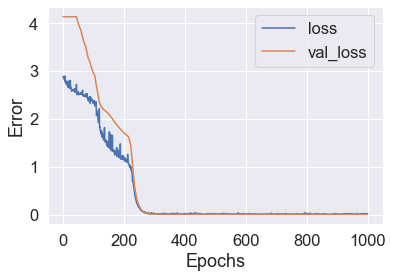

In [91]:
model = Sequential()
model.add(BatchNormalization())
model.add(Dense(X_train.shape[1], input_dim = X_train.shape[1], activation='linear'))
model.add(BatchNormalization())
model.add(Dense(1, activation='relu'))
model.compile(loss='mse', optimizer="adam", metrics=['mse', 'mae'])
history = model.fit(X_train, y_train,
                    epochs=1000,
                    verbose=1,
                    validation_data=(X_test, y_test))

plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()
plt.show()

In [92]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Batc  (None, 4)                16        
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 batch_normalization_3 (Batc  (None, 4)                16        
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 57
Trainable params: 41
Non-trainable params: 16
_________________________________________________________________


In [93]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 16ms/step - loss: 0.0042 - mse: 0.0042 - mae: 0.0521


[0.004249678924679756, 0.004249678924679756, 0.052080754190683365]

In [94]:
y_preds = model.predict(X_test)

1/1 [==============================] - 0s 42ms/step


In [95]:
print(y_test)

[2.48 1.72 1.86 2.54 2.52 1.8  1.96 2.   1.84 1.82 1.76 2.48 1.96 1.76
 2.48 1.8  1.76 1.84 2.08 2.28 1.76 1.78]


In [96]:
X_test

array([[ 45. , 140. ,   4.5,  80. ],
       [ 43. , 146. ,   9. ,  60. ],
       [ 46. , 141. ,  10. ,  80. ],
       [ 47. , 139. ,   4.5,  80. ],
       [ 47. , 139. ,   4.5,  80. ],
       [ 44. , 146. ,   9. ,  60. ],
       [ 45. , 140. ,   8. ,  80. ],
       [ 48. , 131. ,  10. , 125. ],
       [ 45. , 141. ,  10. ,  80. ],
       [ 43. , 150. ,   9. ,  50. ],
       [ 46. , 146. ,  10. ,  60. ],
       [ 47. , 139. ,   4.5,  80. ],
       [ 45. , 140. ,   8. ,  80. ],
       [ 46. , 146. ,  10. ,  60. ],
       [ 45. , 140. ,   4.5,  80. ],
       [ 47. , 141. ,  12. ,  80. ],
       [ 44. , 146. ,   9. ,  60. ],
       [ 44. , 146. ,   9. ,  60. ],
       [ 48. , 131. ,  10. , 125. ],
       [ 49. , 132. ,   8. , 125. ],
       [ 44. , 146. ,   9. ,  60. ],
       [ 46. , 141. ,  10. ,  80. ]])

In [97]:
print(y_preds)

[[2.433447 ]
 [1.7887583]
 [1.8249632]
 [2.4824014]
 [2.4824014]
 [1.8019395]
 [2.0522184]
 [2.060649 ]
 [1.811782 ]
 [1.7020788]
 [1.7193794]
 [2.4824014]
 [2.0522184]
 [1.7193794]
 [2.433447 ]
 [1.6202996]
 [1.8019395]
 [1.8019395]
 [2.060649 ]
 [2.269083 ]
 [1.8019395]
 [1.8249632]]


In [98]:
print(" MAE =", mean_absolute_error(y_test, y_preds), "\n", 
    "MSE =", mean_squared_error(y_test, y_preds), "\n", 
     "R_squared =", r2_score(y_test,y_preds))

 MAE = 0.05208075978539208 
 MSE = 0.004249680204027137 
 R_squared = 0.9502177027565268


In [99]:
res4 = ['Width', 
         'Neural', 
         mean_absolute_error(y_test, y_preds), 
         mean_squared_error(y_test, y_preds), 
         r2_score(y_test, y_preds)]
results_comp.append(res4)

In [100]:
model.save('./model_Width.h5')

In [101]:
loaded_width_model= load_model('./model_Width.h5')

In [102]:
loaded_width_model.predict(X_test)

1/1 [==============================] - 0s 42ms/step


array([[2.433447 ],
       [1.7887583],
       [1.8249632],
       [2.4824014],
       [2.4824014],
       [1.8019395],
       [2.0522184],
       [2.060649 ],
       [1.811782 ],
       [1.7020788],
       [1.7193794],
       [2.4824014],
       [2.0522184],
       [1.7193794],
       [2.433447 ],
       [1.6202996],
       [1.8019395],
       [1.8019395],
       [2.060649 ],
       [2.269083 ],
       [1.8019395],
       [1.8249632]], dtype=float32)

## 3.1.3 Решающий лес

In [103]:
tree = DecisionTreeRegressor()

In [104]:
tree.fit(X_train, y_train)

DecisionTreeRegressor()

In [105]:
y_pred_tree = tree.predict(X_test)

In [106]:
print(" MAE =", mean_absolute_error(y_test, y_pred_tree), "\n", 
    "MSE =", mean_squared_error(y_test, y_pred_tree), "\n", 
     "R_squared =", r2_score(y_test, y_pred_tree))

 MAE = 0.0363939393939394 
 MSE = 0.0019692777777777807 
 R_squared = 0.9769311649390939


In [107]:
res6 = ['Width', 
         'Decision Tree', 
         mean_absolute_error(y_test, y_pred_tree), 
         mean_squared_error(y_test, y_pred_tree), 
         r2_score(y_test, y_pred_tree)]
results_comp.append(res6)

# 3.1.4 Случайный лес

In [108]:
model = RandomForestRegressor(n_estimators = 8, random_state=30)
model.fit(X_train, y_train)
y_pred_RF = model.predict(X_test)

In [109]:
print(" MAE =", mean_absolute_error(y_test, y_pred_RF), "\n", 
    "MSE =", mean_squared_error(y_test, y_pred_RF), "\n", 
     "R_squared =", r2_score(y_test,y_pred_RF))

 MAE = 0.04858658008658006 
 MSE = 0.004062083748482556 
 R_squared = 0.9524152757651716


In [110]:
res8 = ['Width', 
         'Random Forest', 
         mean_absolute_error(y_test, y_pred_RF), 
         mean_squared_error(y_test, y_pred_RF), 
         r2_score(y_test, y_pred_RF)]
results_comp.append(res8)

# 4 Результаты

In [111]:
df_results = pd.DataFrame(results_comp, columns = ['Predictor', 'Method', 'MAE', 'MSE', 'R_squared'])

In [112]:
df_results[df_results.Predictor=='Depth']

,Predictor,Method,MAE,MSE,R_squared
0,Depth,LinearRegression,0.101701,0.017277,0.697671
1,Depth,Neural,0.103562,0.017738,0.689602
2,Depth,Decision Tree,0.066727,0.006861,0.879949
3,Depth,Random Forest,0.070118,0.007540,0.868065


In [113]:
df_results[df_results.Predictor=='Width']

,Predictor,Method,MAE,MSE,R_squared
4,Width,LinearRegression,0.047721,0.003766,0.955878
5,Width,Neural,0.052081,0.004250,0.950218
6,Width,Decision Tree,0.036394,0.001969,0.976931
7,Width,Random Forest,0.048587,0.004062,0.952415
